# American Options Dashboard
## Bjerksund-Stensland Model for Option Pricing and Hedge Management

This dashboard allows you to:
- Price American options using the Bjerksund-Stensland approximation
- Manage multiple option positions
- Analyze hedge effectiveness against a notional position
- Calculate and visualize Greeks (Delta, Gamma, Vega, Theta, Rho)
- Perform scenario analysis

In [1]:
import warnings
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from pathlib import Path
try:
    import yaml
    YAML_AVAILABLE = True
except ImportError:
    YAML_AVAILABLE = False
    print("⚠️  PyYAML not installed. YAML configuration features disabled.")
    print("   Install with: pip install PyYAML")

from deltadewa import OptionPortfolio

warnings.filterwarnings('ignore')

# Configure export directory
EXPORT_DIR = Path('exports')  # Change this to your preferred location
EXPORT_DIR.mkdir(exist_ok=True)

# Configure pandas display
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)

# Configure matplotlib
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

In [2]:
yaml_config_path = Path('portfolio_config_example.yaml')

In [3]:
# YAML Configuration Loading Utilities
# Provide functions to load/save simple portfolio YAML configs.
# If PyYAML is not available, the utilities will be disabled gracefully.
if not YAML_AVAILABLE:
    print("⚠️  YAML features disabled - PyYAML not installed")
    yaml_config = None
else:
    from pathlib import Path

    def load_portfolio_config_yaml(filepath: Path = Path('portfolio_config.yaml')):
        """
        Load portfolio configuration from a YAML file.

        Returns a dict containing at least 'market_parameters' and 'positions',
        or None if the file is missing or invalid.
        """
        if not filepath.exists():
            return None
        try:
            with open(filepath, 'r') as f:
                config = yaml.safe_load(f)

            if not isinstance(config, dict):
                raise ValueError("YAML root must be a mapping/object")

            # Basic structure validation
            if 'market_parameters' not in config:
                raise ValueError("YAML must contain 'market_parameters' section")
            if 'positions' not in config:
                raise ValueError("YAML must contain 'positions' section")

            required_params = ['spot_price', 'volatility', 'risk_free_rate', 'dividend_yield']
            for param in required_params:
                if param not in config['market_parameters']:
                    raise ValueError(f"Missing required market parameter: {param}")

            return config
        except yaml.YAMLError as e:
            print(f"Error parsing YAML file: {e}")
            return None
        except Exception as e:
            print(f"Error loading YAML configuration: {e}")
            return None

    def export_portfolio_to_yaml(portfolio, market_params, filename='portfolio_export.yaml'):
        """
        Export portfolio configuration to a simple YAML format useful for edits/versioning.

        The saved structure contains 'market_parameters' and a list of 'positions' with
        option_type, strike_price, maturity_days (relative), quantity and symbol.
        Returns the Path to the saved file.
        """
        # Build configuration structure
        config = {
            'market_parameters': {
                'spot_price': market_params['spot_price'],
                'volatility': market_params['volatility'],
                'risk_free_rate': market_params['risk_free_rate'],
                'dividend_yield': market_params['dividend_yield'],
                # Optional fields
                'notional_position': getattr(portfolio, 'notional_position', None),
                'symbol': market_params.get('symbol', 'UNKNOWN')
            },
            'positions': []
        }

        today = datetime.now()
        for pos in portfolio.positions:
            days_to_maturity = (pos.option.maturity_date - today).days
            position_data = {
                'option_type': pos.option.option_type,
                'strike_price': float(pos.option.strike_price),
                'maturity_days': max(1, days_to_maturity),
                'quantity': int(pos.quantity),
                'symbol': getattr(pos, 'symbol', None)
            }
            config['positions'].append(position_data)

        output_path = EXPORT_DIR / filename
        with open(output_path, 'w') as f:
            yaml.dump(config, f, default_flow_style=False, sort_keys=False)

        return output_path

    # Try to load yaml_config_path if it exists
    yaml_config = load_portfolio_config_yaml(yaml_config_path)
    if yaml_config:
        print("=" * 80)
        print("✓ YAML CONFIGURATION LOADED")
        print("=" * 80)
        print(f"File: {yaml_config_path}")
        print(f"Positions: {len(yaml_config.get('positions', []))}")
        print("\nMarket parameters will be loaded from YAML.")
        print("=" * 80)
    else:
        # Keep yaml_config as None when no config found
        yaml_config = None
        print(f"ℹ️  No {yaml_config_path} found - will use hardcoded defaults")
        print("\n📦 YAML utilities loaded:")
        print("  • load_portfolio_config_yaml(filepath)")
        print("  • export_portfolio_to_yaml(portfolio, market_params, filename)")

✓ YAML CONFIGURATION LOADED
File: portfolio_config_example.yaml
Positions: 15

Market parameters will be loaded from YAML.


## 1. Market Parameters Setup

Define the market conditions and underlying asset parameters.

In [4]:
# Market Parameters
# Load from YAML if available, otherwise use defaults

if yaml_config and 'market_parameters' in yaml_config:
    # Load from YAML configuration
    market_params = yaml_config['market_parameters']
    spot_price = market_params['spot_price']
    volatility = market_params['volatility']
    risk_free_rate = market_params['risk_free_rate']
    dividend_yield = market_params['dividend_yield']
    notional_position = market_params.get('notional_position', 0.0)
    
    print("="*80)
    print("📁 MARKET PARAMETERS LOADED FROM YAML")
    print("="*80)
else:
    # Default hardcoded values
    spot_price = 100.0        # Current underlying price
    volatility = 0.25         # 25% annualized volatility
    risk_free_rate = 0.05     # 5% risk-free rate
    dividend_yield = 0.02     # 2% dividend yield
    notional_position = 1000.0  # Long 1000 shares
    
    print("="*80)
    print("📝 USING DEFAULT MARKET PARAMETERS (no YAML config found)")
    print("="*80)

print(f"Spot Price: ${spot_price}")
print(f"Volatility: {volatility*100}%")
print(f"Risk-Free Rate: {risk_free_rate*100}%")
print(f"Dividend Yield: {dividend_yield*100}%")
print(f"Notional Position: {notional_position:,.0f} shares")
print("="*80)


📁 MARKET PARAMETERS LOADED FROM YAML
Spot Price: $100.0
Volatility: 25.0%
Risk-Free Rate: 5.0%
Dividend Yield: 2.0%
Notional Position: 1,000 shares


## 2. Create Portfolio and Add Positions

Build a portfolio with multiple option positions.

In [5]:
# Initialize portfolio
# Define maturity dates (3 different dates)
today = datetime.now()

portfolio = OptionPortfolio(
    notional_position=notional_position,
    spot_price=spot_price,
    volatility=volatility,
    risk_free_rate=risk_free_rate,
    dividend_yield=dividend_yield,
    valuation_date=today
)

# Load positions from YAML if available, otherwise use default positions
if yaml_config and 'positions' in yaml_config:
    print("="*80)
    print("📁 LOADING POSITIONS FROM YAML")
    print("="*80)
    
    # Add positions from YAML
    for pos_config in yaml_config['positions']:
        # Determine maturity date
        if 'maturity_date' in pos_config:
            # Absolute date specified
            maturity = datetime.fromisoformat(pos_config['maturity_date'])
        elif 'maturity_days' in pos_config:
            # Relative days from today
            maturity = today + timedelta(days=pos_config['maturity_days'])
        else:
            print("⚠️  Skipping position: no maturity specified")
            continue
        
        # Add position
        portfolio.add_position(
            strike_price=pos_config['strike_price'],
            maturity_date=maturity,
            quantity=pos_config['quantity'],
            option_type=pos_config['option_type'].lower(),
            symbol=pos_config.get('symbol', yaml_config['market_parameters'].get('symbol', 'UNKNOWN'))
        )
    
    print(f"✓ Loaded {len(portfolio.positions)} positions from YAML")
    print("="*80)
    
else:
    # Default positions (backward compatibility)
    print("="*80)
    print("📝 CREATING DEFAULT PORTFOLIO POSITIONS")
    print("="*80)
    
    maturity_30d = today + timedelta(days=30)
    maturity_60d = today + timedelta(days=60)
    maturity_90d = today + timedelta(days=90)

    # Example: Add 20 long puts across different strikes and maturities
    # Strike prices: 6 different levels (90, 95, 100, 105, 110, 115)
    strikes = [90, 95, 100, 105, 110, 115]
    maturities = [maturity_30d, maturity_60d, maturity_90d]

    # Long puts for downside protection
    for strike in [90, 95, 100]:
        for maturity in maturities:
            quantity = 2 if strike == 95 else 3  # More ATM puts
            portfolio.add_position(
                strike_price=strike,
                maturity_date=maturity,
                quantity=quantity,
                option_type="put",
                symbol="SPY"
            )

    # Short calls for upside income (covered calls)
    for strike in [105, 110, 115]:
        for maturity in maturities[:2]:  # Only 30d and 60d
            portfolio.add_position(
                strike_price=strike,
                maturity_date=maturity,
                quantity=-2,  # Short positions
                option_type="call",
                symbol="SPY"
            )
    
    print(f"✓ Created default portfolio with {len(portfolio.positions)} positions")
    print("="*80)

print(f"\nPortfolio Summary: {portfolio.summary()}")


📁 LOADING POSITIONS FROM YAML
✓ Loaded 15 positions from YAML

Portfolio Summary: Positions: 15, Value: $3,929.56, Net Delta: 104.75, Gamma: 44.2053, Vega: 192.04, Theta: -30.19


## 2a. Edit Positions (Interactive)

Interactively edit, update, or remove option positions from the portfolio.

In [6]:
# Interactive Position Editor
from datetime import datetime, timedelta

# Create widgets for position editing
position_selector = widgets.Dropdown(
    options=[],
    description='Select Position:',
    style={'description_width': '120px'},
    layout=widgets.Layout(width='400px'),
    disabled=True
)

quantity_input = widgets.IntText(
    value=0,
    description='Quantity:',
    style={'description_width': '120px'},
    layout=widgets.Layout(width='300px')
)

strike_input = widgets.FloatText(
    value=0.0,
    description='Strike:',
    style={'description_width': '120px'},
    layout=widgets.Layout(width='300px')
)

option_type_selector = widgets.Dropdown(
    options=['Call', 'Put'],
    value='Call',
    description='Option Type:',
    style={'description_width': '120px'},
    layout=widgets.Layout(width='300px')
)

expiry_input = widgets.DatePicker(
    description='Expiry Date:',
    value=datetime.now().date() + timedelta(days=30),
    style={'description_width': '120px'},
    layout=widgets.Layout(width='300px')
)

add_button = widgets.Button(
    description='Add Position',
    button_style='success',
    layout=widgets.Layout(width='150px')
)

remove_button = widgets.Button(
    description='Remove Position',
    button_style='danger',
    layout=widgets.Layout(width='150px')
)

update_button = widgets.Button(
    description='Update Position',
    button_style='info',
    layout=widgets.Layout(width='150px')
)

status_label = widgets.Label(value='')

# Create output widget for display
output = widgets.Output()

def refresh_position_list():
    """Update the dropdown with current positions"""
    positions = portfolio.get_positions()
    if positions:
        position_selector.options = [f"{p['symbol']} - {p['type']} {p['strike']} @ {p['expiry']}" for p in positions]
        position_selector.disabled = False
    else:
        position_selector.options = ['No positions']
        position_selector.disabled = True

def on_position_selected(change):
    """Load selected position data into input fields"""
    if position_selector.value and position_selector.value != 'No positions':
        positions = portfolio.get_positions()
        for i, p in enumerate(positions):
            if position_selector.value == f"{p['symbol']} - {p['type']} {p['strike']} @ {p['expiry']}":
                quantity_input.value = p['quantity']
                strike_input.value = p['strike']
                option_type_selector.value = 'Call' if p['type'] == 'Call' else 'Put'
                expiry_input.value = p['expiry']
                break

def on_add_clicked(b):
    """Add a new position"""
    try:
        portfolio.add_position(
            strike_price=strike_input.value,
            maturity_date=datetime.combine(expiry_input.value, datetime.min.time()),
            option_type='call' if option_type_selector.value == 'Call' else 'put',
            quantity=quantity_input.value,
            symbol='SPY'
        )
        status_label.value = f'✓ Added {quantity_input.value} {option_type_selector.value} @ {strike_input.value}'
        refresh_position_list()
        with output:
            output.clear_output()
            print(portfolio.summary())
    except Exception as e:
        status_label.value = f'✗ Error: {str(e)}'

def on_remove_clicked(b):
    """Remove selected position"""
    if position_selector.value and position_selector.value != 'No positions':
        try:
            positions = portfolio.get_positions()
            for i, p in enumerate(positions):
                if position_selector.value == f"{p['symbol']} - {p['type']} {p['strike']} @ {p['expiry']}":
                    portfolio.remove_position(i)
                    status_label.value = f'✓ Removed position {position_selector.value}'
                    refresh_position_list()
                    with output:
                        output.clear_output()
                        print(portfolio.summary())
                    break
        except Exception as e:
            status_label.value = f'✗ Error: {str(e)}'

def on_update_clicked(b):
    """Update selected position"""
    if position_selector.value and position_selector.value != 'No positions':
        try:
            positions = portfolio.get_positions()
            for i, p in enumerate(positions):
                if position_selector.value == f"{p['symbol']} - {p['type']} {p['strike']} @ {p['expiry']}":
                    portfolio.update_position(
                        i,
                        quantity=quantity_input.value,
                        strike=strike_input.value,
                        expiry=datetime.combine(expiry_input.value, datetime.min.time()),
                        option_type='call' if option_type_selector.value == 'Call' else 'put'
                    )
                    status_label.value = f'✓ Updated position {position_selector.value}'
                    refresh_position_list()
                    with output:
                        output.clear_output()
                        print(portfolio.summary())
                    break
        except Exception as e:
            status_label.value = f'✗ Error: {str(e)}'

# Connect event handlers
position_selector.observe(on_position_selected, names='value')
add_button.on_click(on_add_clicked)
remove_button.on_click(on_remove_clicked)
update_button.on_click(on_update_clicked)

# Initial refresh
refresh_position_list()

# Display the interface
display(widgets.VBox([
    widgets.HTML('<h3>Position Management</h3>'),
    position_selector,
    widgets.HBox([quantity_input, strike_input]),
    widgets.HBox([option_type_selector, expiry_input]),
    widgets.HBox([add_button, update_button, remove_button]),
    status_label,
    output
]))

## 2b. Roll Analysis (What-If Comparison)

Compare current positions to proposed rolls before committing changes. Analyze P&L impact and Greek deltas for rolling to different strikes or maturities.

In [7]:
# Roll Analysis - Compare Current vs Proposed Positions
from deltadewa import AmericanOption
from deltadewa.portfolio import OptionPosition

# Widgets for roll analysis
roll_position_selector = widgets.Dropdown(
    options=[],
    description='Position to Roll:',
    style={'description_width': '120px'},
    layout=widgets.Layout(width='500px'),
    disabled=True
)

roll_type = widgets.RadioButtons(
    options=['Roll Strike (same maturity)', 'Roll Maturity (same strike)', 'Roll Both'],
    value='Roll Maturity (same strike)',
    description='Roll Type:',
    style={'description_width': '120px'}
)

new_strike_input = widgets.FloatText(
    value=100.0,
    description='New Strike:',
    style={'description_width': '120px'},
    layout=widgets.Layout(width='300px')
)

new_maturity_date = widgets.DatePicker(
    value=datetime.now().date() + timedelta(days=30),
    description='New Maturity:',
    style={'description_width': '120px'},
    layout=widgets.Layout(width='300px')
)

new_quantity_input = widgets.IntText(
    value=0,
    description='New Quantity:',
    style={'description_width': '120px'},
    layout=widgets.Layout(width='300px'),
    disabled=False
)

analyze_button = widgets.Button(
    description='Analyze Roll',
    button_style='info',
    layout=widgets.Layout(width='150px')
)

commit_roll_button = widgets.Button(
    description='Commit Roll',
    button_style='success',
    layout=widgets.Layout(width='150px'),
    disabled=True
)

roll_output = widgets.Output()

# Store the proposed position for commit
proposed_position = None
current_position_idx = None

def refresh_roll_selector():
    """Refresh the roll position selector dropdown."""
    if len(portfolio.positions) == 0:
        roll_position_selector.options = []
        roll_position_selector.disabled = True
    else:
        options = []
        for idx, pos in enumerate(portfolio.positions):
            label = f"{idx}: {pos.option.option_type.upper()} K={pos.option.strike_price} " \
                    f"T={pos.option.maturity_date.strftime('%Y-%m-%d')} Qty={pos.quantity}"
            options.append((label, idx))
        roll_position_selector.options = options
        roll_position_selector.disabled = False

def on_roll_position_selected(change):
    """Load selected position data for roll analysis."""
    global proposed_position, current_position_idx
    proposed_position = None
    current_position_idx = None
    commit_roll_button.disabled = True
    
    if change['new'] is not None:
        idx = change['new']
        pos = portfolio.positions[idx]
        new_strike_input.value = pos.option.strike_price
        new_maturity_date.value = pos.option.maturity_date.date()
        new_quantity_input.value = pos.quantity

def on_analyze_roll(b):
    """Analyze the proposed roll and show comparison table."""
    global proposed_position, current_position_idx
    
    with roll_output:
        roll_output.clear_output(wait=True)
        
        if roll_position_selector.value is None:
            print("⚠ No position selected")
            commit_roll_button.disabled = True
            return
        
        idx = roll_position_selector.value
        current_position_idx = idx
        current_pos = portfolio.positions[idx]
        
        # Determine new parameters based on roll type
        if roll_type.value == 'Roll Strike (same maturity)':
            new_strike = new_strike_input.value
            new_maturity = current_pos.option.maturity_date
            roll_desc = f"Strike: {current_pos.option.strike_price} → {new_strike}"
        elif roll_type.value == 'Roll Maturity (same strike)':
            new_strike = current_pos.option.strike_price
            new_maturity = datetime.combine(new_maturity_date.value, datetime.min.time())
            roll_desc = f"Maturity: {current_pos.option.maturity_date.strftime('%Y-%m-%d')} → {new_maturity.strftime('%Y-%m-%d')}"
        else:  # Roll Both
            new_strike = new_strike_input.value
            new_maturity = datetime.combine(new_maturity_date.value, datetime.min.time())
            roll_desc = f"Strike: {current_pos.option.strike_price} → {new_strike}, " \
                       f"Maturity: {current_pos.option.maturity_date.strftime('%Y-%m-%d')} → {new_maturity.strftime('%Y-%m-%d')}"
        
        # Create proposed option (what-if)
        proposed_option = AmericanOption(
            spot_price=spot_price,
            strike_price=new_strike,
            maturity_date=new_maturity,
            volatility=volatility,
            risk_free_rate=risk_free_rate,
            dividend_yield=dividend_yield,
            option_type=current_pos.option.option_type,
            valuation_date=portfolio.valuation_date
        )
        
        proposed_position = OptionPosition(proposed_option, new_quantity_input.value)
        
        # Calculate metrics for comparison
        current_metrics = {
            'Quantity': current_pos.quantity,
            'Strike': current_pos.option.strike_price,
            'Maturity': current_pos.option.maturity_date.strftime('%Y-%m-%d'),
            'Days to Exp': (current_pos.option.maturity_date - datetime.now()).days,
            'Price': current_pos.option.price(),
            'Delta': current_pos.position_delta(),
            'Gamma': current_pos.position_gamma(),
            'Vega': current_pos.position_vega(),
            'Theta': current_pos.position_theta(),
            'Position Value': current_pos.position_value(),
        }
        
        proposed_metrics = {
            'Quantity': proposed_position.quantity,
            'Strike': proposed_position.option.strike_price,
            'Maturity': proposed_position.option.maturity_date.strftime('%Y-%m-%d'),
            'Days to Exp': (proposed_position.option.maturity_date - datetime.now()).days,
            'Price': proposed_position.option.price(),
            'Delta': proposed_position.position_delta(),
            'Gamma': proposed_position.position_gamma(),
            'Vega': proposed_position.position_vega(),
            'Theta': proposed_position.position_theta(),
            'Position Value': proposed_position.position_value(),
        }
        
        # Calculate deltas
        deltas = {}
        for key in current_metrics:
            if key in ['Maturity']:
                deltas[key] = proposed_metrics[key]  # Just show new value for dates
            elif isinstance(current_metrics[key], (int, float)):
                deltas[key] = proposed_metrics[key] - current_metrics[key]
            else:
                deltas[key] = proposed_metrics[key]
        
        # Create comparison DataFrame
        comparison_df = pd.DataFrame({
            'Current': current_metrics,
            'Proposed': proposed_metrics,
            'Delta': deltas
        })
        
        # Display results
        print("=" * 80)
        print(f"ROLL ANALYSIS: {current_pos.option.option_type.upper()} Position #{idx}")
        print("=" * 80)
        print(f"\nRoll: {roll_desc}")
        print(f"\n{comparison_df.to_string()}\n")
        
        # Highlight key changes
        pnl_change = deltas['Position Value']
        print(f"{'=' * 80}")
        print(f"P&L Impact: ${pnl_change:,.2f} ({'gain' if pnl_change > 0 else 'loss'})")
        print(f"Delta Change: {deltas['Delta']:,.2f}")
        print(f"Gamma Change: {deltas['Gamma']:,.4f}")
        print(f"Vega Change: {deltas['Vega']:,.2f}")
        print(f"Theta Change: {deltas['Theta']:,.2f}")
        print(f"{'=' * 80}")
        
        # Enable commit button
        commit_roll_button.disabled = False
        print("\n✓ Analysis complete. Click 'Commit Roll' to apply changes to portfolio.")

def on_commit_roll(b):
    """Commit the analyzed roll to the portfolio."""
    global proposed_position, current_position_idx
    
    with roll_output:
        if proposed_position is None or current_position_idx is None:
            print("\n⚠ No roll analyzed. Please click 'Analyze Roll' first.")
            return
        
        # Replace the current position with the proposed position
        portfolio.positions[current_position_idx] = proposed_position
        
        print(f"\n✓✓ Roll committed! Position #{current_position_idx} updated in portfolio.")
        print(f"   {proposed_position.option.option_type.upper()} " \
              f"K={proposed_position.option.strike_price} " \
              f"T={proposed_position.option.maturity_date.strftime('%Y-%m-%d')} " \
              f"Qty={proposed_position.quantity}")
        
        # Reset state
        proposed_position = None
        current_position_idx = None
        commit_roll_button.disabled = True
        
        # Refresh selectors
        refresh_roll_selector()
        refresh_position_list()

# Wire up event handlers
roll_position_selector.observe(on_roll_position_selected, names='value')
analyze_button.on_click(on_analyze_roll)
commit_roll_button.on_click(on_commit_roll)

# Initial refresh
refresh_roll_selector()

# Display the roll analysis panel
display(widgets.VBox([
    widgets.HTML("<h3>Roll Analysis & Comparison</h3>"),
    roll_position_selector,
    roll_type,
    widgets.HTML("<h4>Proposed Roll Parameters</h4>"),
    new_strike_input,
    new_maturity_date,
    new_quantity_input,
    widgets.HBox([analyze_button, commit_roll_button]),
    roll_output
]))

print("Roll analyzer ready. Select a position to analyze potential rolls.")

Roll analyzer ready. Select a position to analyze potential rolls.


## 3. Portfolio Summary

View all positions and their Greeks.

In [8]:
# Display portfolio positions
df_positions = portfolio.to_dataframe()

# Style the dataframe
styled_df = df_positions.style.format({
    'strike': '{:.2f}',
    'quantity': '{:.0f}',
    'price': '{:.4f}',
    'position_value': '{:.2f}',
    'delta': '{:.4f}',
    'position_delta': '{:.2f}',
    'gamma': '{:.6f}',
    'position_gamma': '{:.4f}',
    'vega': '{:.4f}',
    'position_vega': '{:.2f}',
    'theta': '{:.4f}',
    'position_theta': '{:.2f}',
    'rho': '{:.4f}',
    'position_rho': '{:.2f}',
}).background_gradient(subset=['position_value'], cmap='RdYlGn')

display(styled_df)

,symbol,type,strike,maturity,quantity,price,position_value,delta,position_delta,gamma,position_gamma,vega,position_vega,theta,position_theta,rho,position_rho,contract_size
0,SPY,put,90.00,2026-01-19,3,0.1972,59.17,-0.0619,-18.56,0.017048,5.1145,0.0349,10.48,-0.0139,-4.18,-0.0050,-1.50,100
1,SPY,put,90.00,2026-02-18,3,0.6751,202.52,-0.1279,-38.37,0.020715,6.2145,0.0846,25.39,-0.0166,-4.98,-0.0205,-6.15,100
2,SPY,put,90.00,2026-03-20,3,1.1636,349.09,-0.1669,-50.08,0.020276,6.0829,0.1238,37.15,-0.0158,-4.75,-0.0399,-11.97,100
3,SPY,put,95.00,2026-01-19,2,0.9171,183.43,-0.2168,-43.36,0.041121,8.2242,0.0840,16.81,-0.0334,-6.69,-0.0170,-3.39,100
4,SPY,put,95.00,2026-02-18,2,1.7947,358.94,-0.2743,-54.86,0.033148,6.6295,0.1347,26.95,-0.0260,-5.19,-0.0425,-8.49,100
5,SPY,put,95.00,2026-03-20,2,2.4994,499.87,-0.2991,-59.83,0.028324,5.6647,0.1717,34.34,-0.0215,-4.30,-0.0690,-13.80,100
6,SPY,put,100.00,2026-01-19,3,2.7456,823.67,-0.4751,-142.54,0.056228,16.8683,0.1138,34.15,-0.0443,-13.28,-0.0347,-10.41,100
7,SPY,put,100.00,2026-02-18,3,3.8154,1144.63,-0.4652,-139.57,0.039972,11.9916,0.1603,48.10,-0.0300,-9.00,-0.0676,-20.29,100
8,SPY,put,100.00,2026-03-20,3,4.6091,1382.72,-0.4578,-137.33,0.032784,9.8352,0.1956,58.68,-0.0237,-7.12,-0.0996,-29.88,100
9,SPY,call,105.00,2026-01-19,-2,1.1444,-228.89,0.2704,-54.07,0.046131,-9.2262,0.0948,-18.95,-0.0417,8.34,0.0213,-4.26,100


## 4. Portfolio Analytics

Key metrics and hedge analysis.

In [9]:
# Get summary statistics
stats = portfolio.summary_stats()

# Create summary display
print("=" * 60)
print("PORTFOLIO SUMMARY")
print("=" * 60)
print(f"Total Positions: {stats['total_positions']}")
print(f"Total Portfolio Value: ${stats['total_value']:,.2f}")
print()
print("DELTA ANALYSIS")
print("-" * 60)
print(f"Portfolio Delta: {stats['total_delta']:,.2f}")
print(f"Notional Position: {stats['notional_position']:,.2f}")
print(f"Net Delta Exposure: {stats['net_delta']:,.2f}")
print(f"Hedge Ratio: {stats['hedge_ratio']:.2f}%")
print(f"Delta Adjustment Needed: {stats['delta_adjustment']:.2f} shares")
print()
print("GREEKS SUMMARY")
print("-" * 60)
print(f"Total Gamma: {stats['total_gamma']:.4f}")
print(f"Total Vega: {stats['total_vega']:.2f}")
print(f"Total Theta (per day): ${stats['total_theta']:.2f}")
print(f"Total Rho: {stats['total_rho']:.2f}")
print("=" * 60)

# Interpretation
print("\nINTERPRETATION:")
if abs(stats['net_delta']) < abs(stats['notional_position']) * 0.1:
    print("✓ Portfolio is well-hedged (net delta < 10% of notional)")
elif stats['net_delta'] * stats['notional_position'] > 0:
    print("⚠ Portfolio is under-hedged (same direction as notional)")
else:
    print("⚠ Portfolio may be over-hedged (opposite direction to notional)")

if stats['total_theta'] < 0:
    print(f"⏰ Portfolio loses ${-stats['total_theta']:.2f} per day due to time decay")
else:
    print(f"⏰ Portfolio gains ${stats['total_theta']:.2f} per day from time decay")

PORTFOLIO SUMMARY
Total Positions: 15
Total Portfolio Value: $3,929.56

DELTA ANALYSIS
------------------------------------------------------------
Portfolio Delta: -895.25
Notional Position: 1,000.00
Net Delta Exposure: 104.75
Hedge Ratio: 89.53%
Delta Adjustment Needed: -104.75 shares

GREEKS SUMMARY
------------------------------------------------------------
Total Gamma: 44.2053
Total Vega: 192.04
Total Theta (per day): $-30.19
Total Rho: -132.38

INTERPRETATION:
⚠ Portfolio is under-hedged (same direction as notional)
⏰ Portfolio loses $30.19 per day due to time decay


## 5. Position Breakdown Visualization

Visualize positions by type, strike, and maturity.

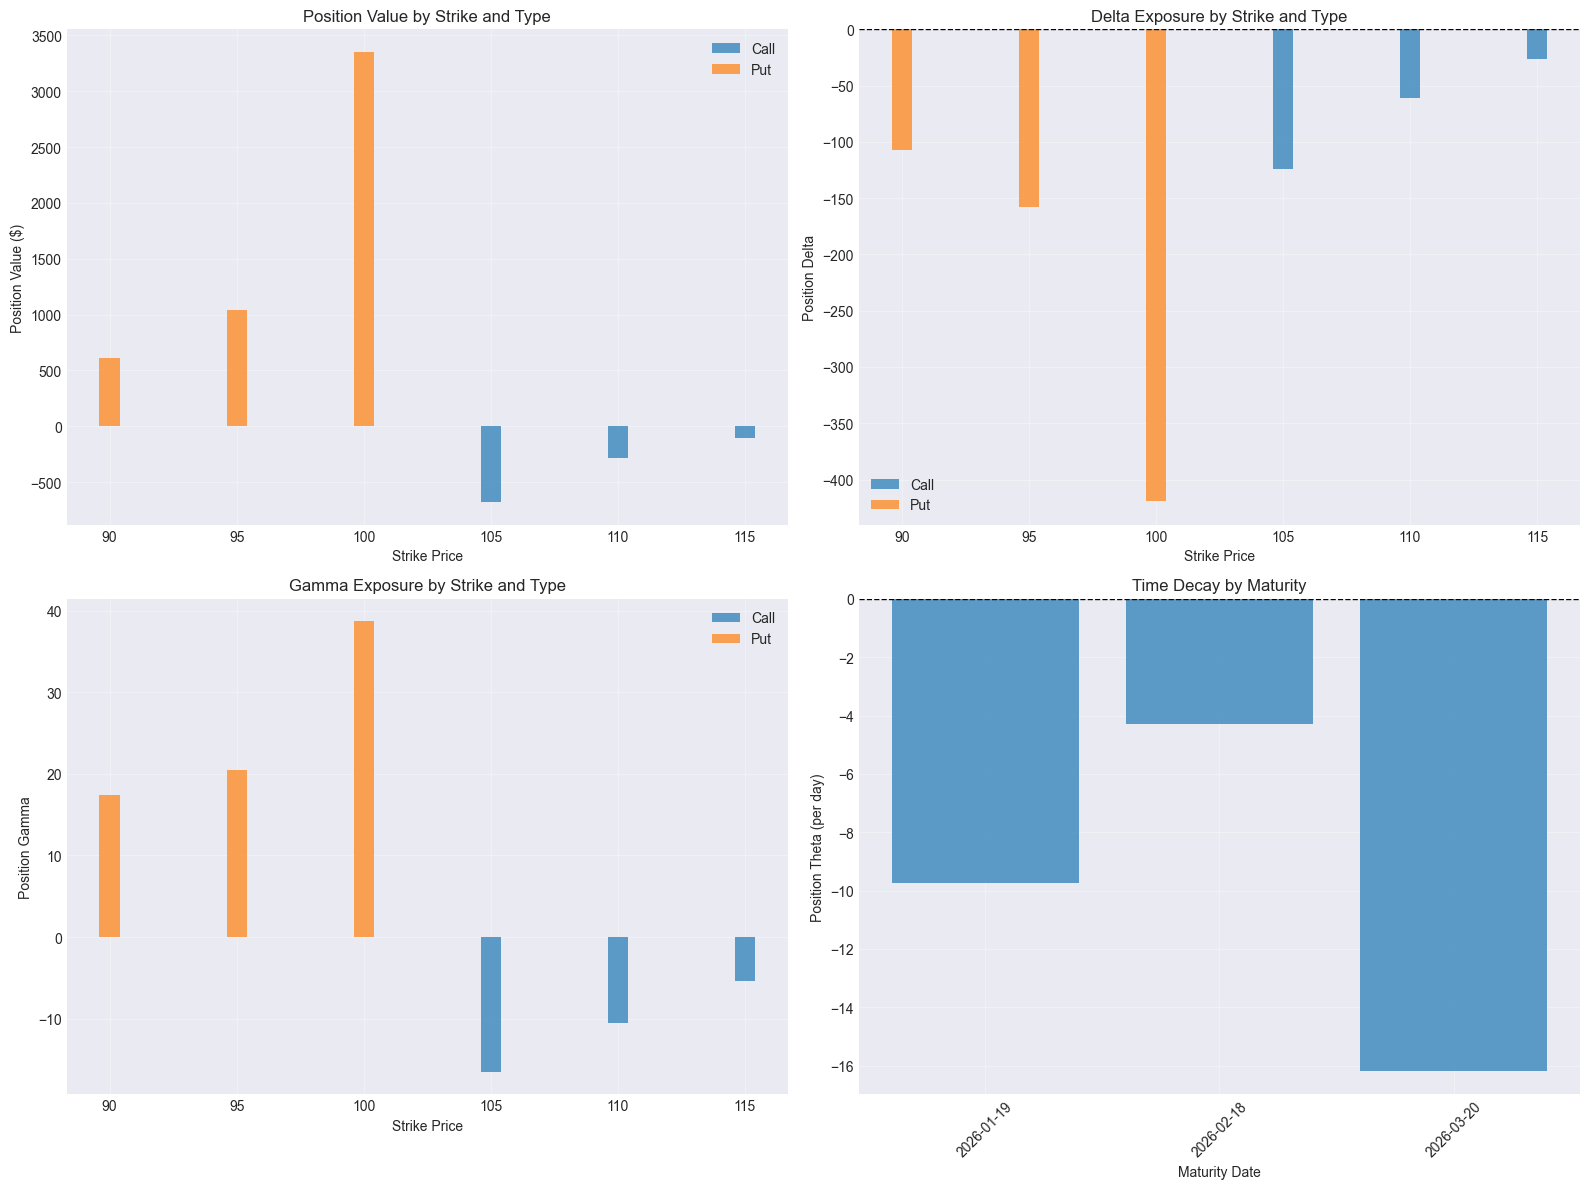

In [10]:
# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Position Value by Strike
df_summary = df_positions.groupby(['type', 'strike']).agg({
    'position_value': 'sum',
    'quantity': 'sum'
}).reset_index()

ax1 = axes[0, 0]
for opt_type in df_summary['type'].unique():
    df_type = df_summary[df_summary['type'] == opt_type]
    ax1.bar(df_type['strike'], df_type['position_value'], 
            alpha=0.7, label=opt_type.capitalize())
ax1.set_xlabel('Strike Price')
ax1.set_ylabel('Position Value ($)')
ax1.set_title('Position Value by Strike and Type')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Delta by Strike
df_delta = df_positions.groupby(['type', 'strike'])['position_delta'].sum().reset_index()

ax2 = axes[0, 1]
for opt_type in df_delta['type'].unique():
    df_type = df_delta[df_delta['type'] == opt_type]
    ax2.bar(df_type['strike'], df_type['position_delta'], 
            alpha=0.7, label=opt_type.capitalize())
ax2.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax2.set_xlabel('Strike Price')
ax2.set_ylabel('Position Delta')
ax2.set_title('Delta Exposure by Strike and Type')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Gamma by Strike
df_gamma = df_positions.groupby(['type', 'strike'])['position_gamma'].sum().reset_index()

ax3 = axes[1, 0]
for opt_type in df_gamma['type'].unique():
    df_type = df_gamma[df_gamma['type'] == opt_type]
    ax3.bar(df_type['strike'], df_type['position_gamma'], 
            alpha=0.7, label=opt_type.capitalize())
ax3.set_xlabel('Strike Price')
ax3.set_ylabel('Position Gamma')
ax3.set_title('Gamma Exposure by Strike and Type')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Theta by Maturity
df_theta = df_positions.groupby('maturity')['position_theta'].sum().reset_index()

ax4 = axes[1, 1]
ax4.bar(range(len(df_theta)), df_theta['position_theta'], alpha=0.7)
ax4.set_xticks(range(len(df_theta)))
ax4.set_xticklabels(df_theta['maturity'], rotation=45)
ax4.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax4.set_xlabel('Maturity Date')
ax4.set_ylabel('Position Theta (per day)')
ax4.set_title('Time Decay by Maturity')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5a. Risk Decomposition by Strike and Maturity

Identify which positions contribute most to portfolio risk across different Greeks. Stacked visualizations help prioritize which legs should be rolled, resized, or closed.

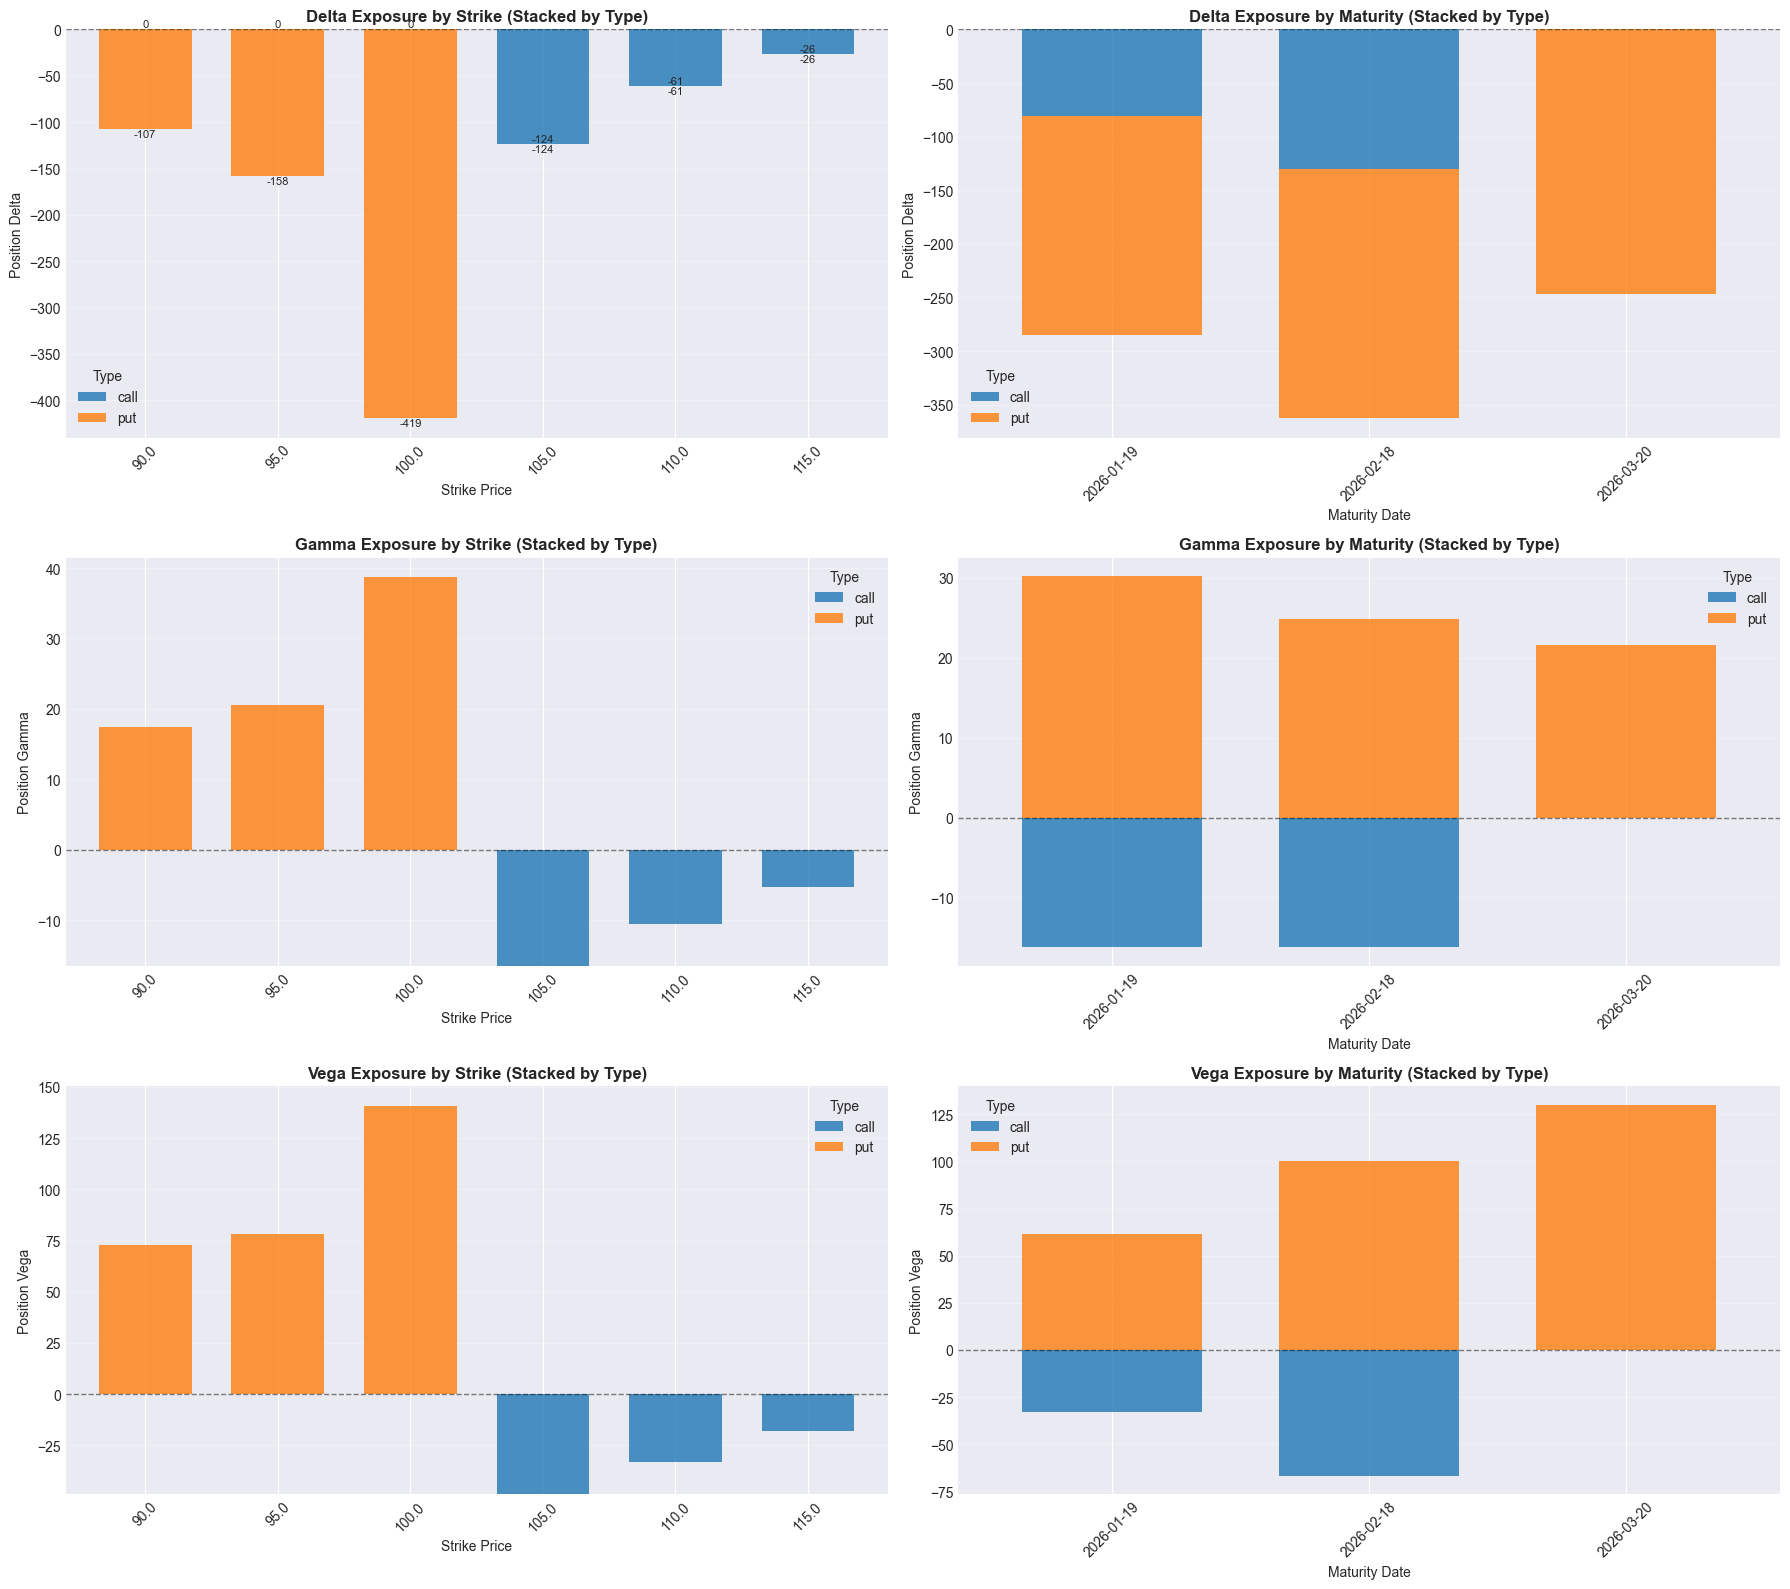


RISK CONCENTRATION ANALYSIS

1. DELTA CONCENTRATION:
--------------------------------------------------------------------------------

Top 3 Strikes by Absolute Delta Exposure:
  Strike $100.0: 419.43 delta (46.9% of total)
  Strike $95.0: 158.04 delta (17.7% of total)
  Strike $105.0: 124.09 delta (13.9% of total)

Top 3 Maturities by Absolute Delta Exposure:
  Maturity 2026-02-18: 362.74 delta (40.5% of total)
  Maturity 2026-01-19: 285.28 delta (31.9% of total)
  Maturity 2026-03-20: 247.24 delta (27.6% of total)

2. GAMMA CONCENTRATION:
--------------------------------------------------------------------------------

Top 3 Strikes by Absolute Gamma Exposure:
  Strike $100.0: 38.6951 gamma (35.5% of total)
  Strike $95.0: 20.5185 gamma (18.8% of total)
  Strike $90.0: 17.4119 gamma (16.0% of total)

3. VEGA CONCENTRATION:
--------------------------------------------------------------------------------

Top 3 Strikes by Absolute Vega Exposure:
  Strike $100.0: 140.92 vega (35.9% of 

In [11]:
# Risk Decomposition Analysis
# Create comprehensive breakdown of Greeks by strike and maturity buckets

fig, axes = plt.subplots(3, 2, figsize=(18, 16))

# Prepare data by grouping positions
df_risk = df_positions.copy()

# Add position identifier for stacking
df_risk['position_id'] = df_risk.apply(
    lambda row: f"{row['type'].upper()[:1]}{int(row['strike'])}", 
    axis=1
)

# ============================================================================
# LEFT COLUMN: Risk by Strike Buckets
# ============================================================================

# 1. Delta by Strike (Stacked by Type)
ax1 = axes[0, 0]
df_delta_strike = df_risk.pivot_table(
    values='position_delta', 
    index='strike', 
    columns='type', 
    aggfunc='sum', 
    fill_value=0
)
df_delta_strike.plot(kind='bar', stacked=True, ax=ax1, alpha=0.8, width=0.7)
ax1.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax1.set_xlabel('Strike Price')
ax1.set_ylabel('Position Delta')
ax1.set_title('Delta Exposure by Strike (Stacked by Type)', fontsize=12, fontweight='bold')
ax1.legend(title='Type', loc='best')
ax1.grid(True, alpha=0.3, axis='y')
ax1.tick_params(axis='x', rotation=45)

# Annotate total per strike
for container in ax1.containers:
    ax1.bar_label(container, fmt='%.0f', label_type='edge', fontsize=8)

# 2. Gamma by Strike (Stacked by Type)
ax2 = axes[1, 0]
df_gamma_strike = df_risk.pivot_table(
    values='position_gamma', 
    index='strike', 
    columns='type', 
    aggfunc='sum', 
    fill_value=0
)
df_gamma_strike.plot(kind='bar', stacked=True, ax=ax2, alpha=0.8, width=0.7)
ax2.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax2.set_xlabel('Strike Price')
ax2.set_ylabel('Position Gamma')
ax2.set_title('Gamma Exposure by Strike (Stacked by Type)', fontsize=12, fontweight='bold')
ax2.legend(title='Type', loc='best')
ax2.grid(True, alpha=0.3, axis='y')
ax2.tick_params(axis='x', rotation=45)

# 3. Vega by Strike (Stacked by Type)
ax3 = axes[2, 0]
df_vega_strike = df_risk.pivot_table(
    values='position_vega', 
    index='strike', 
    columns='type', 
    aggfunc='sum', 
    fill_value=0
)
df_vega_strike.plot(kind='bar', stacked=True, ax=ax3, alpha=0.8, width=0.7)
ax3.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax3.set_xlabel('Strike Price')
ax3.set_ylabel('Position Vega')
ax3.set_title('Vega Exposure by Strike (Stacked by Type)', fontsize=12, fontweight='bold')
ax3.legend(title='Type', loc='best')
ax3.grid(True, alpha=0.3, axis='y')
ax3.tick_params(axis='x', rotation=45)

# ============================================================================
# RIGHT COLUMN: Risk by Maturity Buckets
# ============================================================================

# Convert maturity to string for better display
df_risk['maturity_label'] = pd.to_datetime(df_risk['maturity']).dt.strftime('%Y-%m-%d')

# 4. Delta by Maturity (Stacked by Type)
ax4 = axes[0, 1]
df_delta_mat = df_risk.pivot_table(
    values='position_delta', 
    index='maturity_label', 
    columns='type', 
    aggfunc='sum', 
    fill_value=0
)
df_delta_mat.plot(kind='bar', stacked=True, ax=ax4, alpha=0.8, width=0.7)
ax4.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax4.set_xlabel('Maturity Date')
ax4.set_ylabel('Position Delta')
ax4.set_title('Delta Exposure by Maturity (Stacked by Type)', fontsize=12, fontweight='bold')
ax4.legend(title='Type', loc='best')
ax4.grid(True, alpha=0.3, axis='y')
ax4.tick_params(axis='x', rotation=45)

# 5. Gamma by Maturity (Stacked by Type)
ax5 = axes[1, 1]
df_gamma_mat = df_risk.pivot_table(
    values='position_gamma', 
    index='maturity_label', 
    columns='type', 
    aggfunc='sum', 
    fill_value=0
)
df_gamma_mat.plot(kind='bar', stacked=True, ax=ax5, alpha=0.8, width=0.7)
ax5.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax5.set_xlabel('Maturity Date')
ax5.set_ylabel('Position Gamma')
ax5.set_title('Gamma Exposure by Maturity (Stacked by Type)', fontsize=12, fontweight='bold')
ax5.legend(title='Type', loc='best')
ax5.grid(True, alpha=0.3, axis='y')
ax5.tick_params(axis='x', rotation=45)

# 6. Vega by Maturity (Stacked by Type)
ax6 = axes[2, 1]
df_vega_mat = df_risk.pivot_table(
    values='position_vega', 
    index='maturity_label', 
    columns='type', 
    aggfunc='sum', 
    fill_value=0
)
df_vega_mat.plot(kind='bar', stacked=True, ax=ax6, alpha=0.8, width=0.7)
ax6.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax6.set_xlabel('Maturity Date')
ax6.set_ylabel('Position Vega')
ax6.set_title('Vega Exposure by Maturity (Stacked by Type)', fontsize=12, fontweight='bold')
ax6.legend(title='Type', loc='best')
ax6.grid(True, alpha=0.3, axis='y')
ax6.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# ============================================================================
# Risk Concentration Summary
# ============================================================================

print("\n" + "=" * 80)
print("RISK CONCENTRATION ANALYSIS")
print("=" * 80)

# Analyze Delta concentration
print("\n1. DELTA CONCENTRATION:")
print("-" * 80)
delta_by_strike = df_risk.groupby('strike')['position_delta'].sum().abs()
total_abs_delta = delta_by_strike.sum()
if total_abs_delta > 0:
    print("\nTop 3 Strikes by Absolute Delta Exposure:")
    top_delta_strikes = delta_by_strike.nlargest(3)
    for strike, delta in top_delta_strikes.items():
        pct = (delta / total_abs_delta) * 100
        print(f"  Strike ${strike}: {delta:,.2f} delta ({pct:.1f}% of total)")

delta_by_mat = df_risk.groupby('maturity_label')['position_delta'].sum().abs()
total_abs_delta_mat = delta_by_mat.sum()
if total_abs_delta_mat > 0:
    print("\nTop 3 Maturities by Absolute Delta Exposure:")
    top_delta_mats = delta_by_mat.nlargest(3)
    for mat, delta in top_delta_mats.items():
        pct = (delta / total_abs_delta_mat) * 100
        print(f"  Maturity {mat}: {delta:,.2f} delta ({pct:.1f}% of total)")

# Analyze Gamma concentration
print("\n2. GAMMA CONCENTRATION:")
print("-" * 80)
gamma_by_strike = df_risk.groupby('strike')['position_gamma'].sum().abs()
total_abs_gamma = gamma_by_strike.sum()
if total_abs_gamma > 0:
    print("\nTop 3 Strikes by Absolute Gamma Exposure:")
    top_gamma_strikes = gamma_by_strike.nlargest(3)
    for strike, gamma in top_gamma_strikes.items():
        pct = (gamma / total_abs_gamma) * 100
        print(f"  Strike ${strike}: {gamma:.4f} gamma ({pct:.1f}% of total)")

# Analyze Vega concentration
print("\n3. VEGA CONCENTRATION:")
print("-" * 80)
vega_by_strike = df_risk.groupby('strike')['position_vega'].sum().abs()
total_abs_vega = vega_by_strike.sum()
if total_abs_vega > 0:
    print("\nTop 3 Strikes by Absolute Vega Exposure:")
    top_vega_strikes = vega_by_strike.nlargest(3)
    for strike, vega in top_vega_strikes.items():
        pct = (vega / total_abs_vega) * 100
        print(f"  Strike ${strike}: {vega:,.2f} vega ({pct:.1f}% of total)")

# Actionable insights
print("\n" + "=" * 80)
print("ACTIONABLE INSIGHTS:")
print("=" * 80)
print("\n• Strikes with high concentration (>30%) should be considered for:")
print("  - Rolling to spread risk across multiple strikes")
print("  - Reducing position size if over-concentrated")
print("  - Hedging with offsetting positions at nearby strikes")
print("\n• Maturity buckets with high gamma/vega suggest:")
print("  - Greater sensitivity to market moves and volatility changes")
print("  - Need for more frequent rebalancing as expiry approaches")
print("  - Opportunity to lock in profits by rolling to later dates")
print("\n• Negative stacked bars indicate short exposure requiring monitoring")
print("=" * 80)

## 6. Scenario Analysis

Analyze portfolio P&L across different spot price scenarios.

In [12]:
# Define spot price range for scenario analysis
spot_range = np.linspace(spot_price * 0.8, spot_price * 1.2, 50)

# Calculate min maturity date from portfolio positions (to avoid expired options)
# We use the minimum because we can't value options past their expiration
if portfolio.positions:
    min_maturity = min(pos.option.maturity_date for pos in portfolio.positions)
    max_maturity = max(pos.option.maturity_date for pos in portfolio.positions)
    days_to_min_maturity = (min_maturity - portfolio.valuation_date).days
    days_to_max_maturity = (max_maturity - portfolio.valuation_date).days
else:
    # Fallback if no positions
    days_to_min_maturity = 30
    days_to_max_maturity = 90

# Create date selection widget
# Use minimum maturity minus 1 day to ensure all options can still be valued
max_days = max(1, days_to_min_maturity - 1)
date_range_days = list(range(0, max_days + 1, max(1, max_days // 10)))
if max_days not in date_range_days and max_days > 0:
    date_range_days.append(max_days)

date_options = [(f"Day {d}: {(portfolio.valuation_date + timedelta(days=d)).strftime('%Y-%m-%d')}", d) 
                for d in date_range_days]

date_selector = widgets.SelectionSlider(
    options=date_options,
    value=0,
    description='Valuation Date:',
    style={'description_width': '120px'},
    layout=widgets.Layout(width='700px'),
    continuous_update=False
)

# Output widget for the plot
scenario_output = widgets.Output()

def update_scenario_analysis(days_forward):
    """Update P&L scenario analysis for the selected date."""
    with scenario_output:
        scenario_output.clear_output(wait=True)
        
        # Calculate the valuation date
        valuation_date = portfolio.valuation_date + timedelta(days=days_forward)
        
        # Store original state
        original_spot = portfolio.spot_price
        original_val_date = portfolio.valuation_date
        
        # Update portfolio valuation date
        portfolio.update_market_conditions(valuation_date=valuation_date)
        
        # Calculate current value at the selected date
        # current_value_at_date = portfolio.total_value()
        
        # Run scenario analysis across spot prices at the selected date
        results = []
        for spot in spot_range:
            portfolio.update_market_conditions(spot_price=spot)
            
            results.append({
                'spot_price': spot,
                'portfolio_value': portfolio.total_value(),
                'total_delta': portfolio.total_delta(),
                'net_delta': portfolio.net_delta(),
            })
        
        scenario_df = pd.DataFrame(results)
        
        # Reset to original spot price (but keep the valuation date for current value calculation)
        portfolio.update_market_conditions(spot_price=original_spot)
        current_value_original = portfolio.total_value()
        
        # Calculate P&L from the original position (at original date)
        portfolio.update_market_conditions(valuation_date=original_val_date)
        original_value = portfolio.total_value()
        portfolio.update_market_conditions(valuation_date=valuation_date)
        
        scenario_df['portfolio_pnl'] = scenario_df['portfolio_value'] - original_value
        
        # Calculate underlying P&L
        scenario_df['underlying_pnl'] = (scenario_df['spot_price'] - spot_price) * notional_position
        
        # Calculate total P&L
        scenario_df['total_pnl'] = scenario_df['portfolio_pnl'] + scenario_df['underlying_pnl']
        
        # Plot scenario analysis
        fig, axes = plt.subplots(2, 1, figsize=(14, 10))
        
        # P&L Breakdown
        ax1 = axes[0]
        ax1.plot(scenario_df['spot_price'], scenario_df['portfolio_pnl'], 
                 label='Options P&L', linewidth=2.5)
        ax1.plot(scenario_df['spot_price'], scenario_df['underlying_pnl'], 
                 label='Underlying P&L', linewidth=2.5)
        ax1.plot(scenario_df['spot_price'], scenario_df['total_pnl'], 
                 label='Total P&L', linewidth=2.5, linestyle='--', color='black')
        ax1.axhline(y=0, color='gray', linestyle=':', linewidth=1)
        ax1.axvline(x=spot_price, color='red', linestyle=':', linewidth=1, label='Current Spot')
        ax1.set_xlabel('Spot Price', fontsize=11)
        ax1.set_ylabel('P&L ($)', fontsize=11)
        
        # Add date info to title
        date_str = valuation_date.strftime('%Y-%m-%d')
        if days_forward == 0:
            title_suffix = f" (Today - {date_str})"
        elif days_forward >= days_to_min_maturity - 1:
            title_suffix = f" (Near First Expiration - {date_str})"
        else:
            title_suffix = f" ({days_forward} days forward - {date_str})"
        ax1.set_title(f'P&L Scenario Analysis{title_suffix}', fontsize=13, fontweight='bold')
        ax1.legend(loc='best')
        ax1.grid(True, alpha=0.3)
        
        # Delta Profile
        ax2 = axes[1]
        ax2.plot(scenario_df['spot_price'], scenario_df['total_delta'], 
                 label='Portfolio Delta', linewidth=2.5)
        ax2.plot(scenario_df['spot_price'], scenario_df['net_delta'], 
                 label='Net Delta (with Notional)', linewidth=2.5)
        ax2.axhline(y=0, color='gray', linestyle=':', linewidth=1)
        ax2.axvline(x=spot_price, color='red', linestyle=':', linewidth=1, label='Current Spot')
        ax2.set_xlabel('Spot Price', fontsize=11)
        ax2.set_ylabel('Delta', fontsize=11)
        ax2.set_title('Delta Profile Across Spot Prices', fontsize=13, fontweight='bold')
        ax2.legend(loc='best')
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Restore original market conditions
        portfolio.update_market_conditions(spot_price=original_spot, valuation_date=original_val_date)
        
        # Print key scenarios
        print(f"\n{'='*70}")
        print(f"KEY SCENARIOS (Valuation Date: {date_str}, T+{days_forward} days)")
        print(f"{'='*70}")
        key_spots = [spot_price * 0.9, spot_price, spot_price * 1.1]
        for key_spot in key_spots:
            idx = (np.abs(scenario_df['spot_price'] - key_spot)).argmin()
            row = scenario_df.iloc[idx]
            print(f"\nSpot = ${row['spot_price']:.2f} ({(row['spot_price']/spot_price-1)*100:+.1f}%):")
            print(f"  Options P&L:    ${row['portfolio_pnl']:>10,.2f}")
            print(f"  Underlying P&L: ${row['underlying_pnl']:>10,.2f}")
            print(f"  Total P&L:      ${row['total_pnl']:>10,.2f}")
            print(f"  Net Delta:      {row['net_delta']:>10,.2f}")
        
        # Add time decay information
        if days_forward > 0:
            time_value_decay = original_value - current_value_original
            print(f"\n{'─'*70}")
            print("TIME DECAY (Theta Effect):")
            print(f"  Initial Value:  ${original_value:>10,.2f}")
            print(f"  Value at T+{days_forward}:  ${current_value_original:>10,.2f}")
            print(f"  Time Decay:     ${time_value_decay:>10,.2f} ({(time_value_decay/original_value*100):+.2f}%)")
            
            # Show days until first/last expiration
            days_until_first = days_to_min_maturity - days_forward
            days_until_last = days_to_max_maturity - days_forward
            print(f"\n  Days to first expiration:  {days_until_first}")
            print(f"  Days to last expiration:   {days_until_last}")
        
        print(f"{'='*70}")

# Create interactive widget
widgets.interactive(update_scenario_analysis, days_forward=date_selector)

# Display the widgets
display(widgets.VBox([
    widgets.HTML("<h4>Portfolio P&L across different spot price scenarios</h4>"),
    date_selector,
    scenario_output
]))

# Generate initial plot (today)
update_scenario_analysis(0)

print("\n💡 TIP: Use the slider above to see how the P&L profile changes over time")
print("   • T+0 (Today): Current P&L profile with full time value")
print("   • Intermediate dates: Shows theta decay effect as options approach expiration")
print(f"   • Date range limited to {days_to_min_maturity-1} days (just before first option expires)")
print("   • As expiration approaches, the payoff diagram flattens toward intrinsic value")



💡 TIP: Use the slider above to see how the P&L profile changes over time
   • T+0 (Today): Current P&L profile with full time value
   • Intermediate dates: Shows theta decay effect as options approach expiration
   • Date range limited to 29 days (just before first option expires)
   • As expiration approaches, the payoff diagram flattens toward intrinsic value


## 6a. Interactive Stress Testing with Heatmaps

Visualize portfolio risk across 2D stress scenarios (spot price × volatility) using interactive Plotly heatmaps. Toggle between different metrics (P&L, Net Delta, Vega) and apply common stress presets with quick buttons.

In [13]:
# Import Plotly for interactive heatmaps
import importlib.util

PLOTLY_AVAILABLE = importlib.util.find_spec("plotly") is not None

if PLOTLY_AVAILABLE:
    # import plotly.graph_objects as go
    print("✓ Plotly loaded - interactive heatmaps enabled")
else:
    print("⚠ Plotly not installed. Install with: pip install plotly")
    print("  Continuing without interactive heatmaps...")

✓ Plotly loaded - interactive heatmaps enabled


In [16]:
# Interactive Stress Testing with Heatmaps
# Create 2D stress test visualization across spot price and volatility

# Define stress test parameters
spot_range_pct = 20  # +/- percentage for spot price stress
vol_range_pct = 50   # +/- percentage for volatility stress
num_points = 15      # Resolution of the heatmap grid

# Generate stress scenarios
spot_min = spot_price * (1 - spot_range_pct / 100)
spot_max = spot_price * (1 + spot_range_pct / 100)
spot_scenarios = np.linspace(spot_min, spot_max, num_points)

vol_min = volatility * (1 - vol_range_pct / 100)
vol_max = volatility * (1 + vol_range_pct / 100)
vol_scenarios = np.linspace(vol_min, vol_max, num_points)

# Store original market conditions
original_spot = portfolio.spot_price
original_vol = portfolio.volatility
current_value = portfolio.total_value()

# Metric selection widget
metric_selector = widgets.Dropdown(
    options=[
        ('Portfolio P&L', 'pnl'),
        ('Portfolio Value', 'value'),
        ('Net Delta', 'net_delta'),
        ('Total Gamma', 'gamma'),
        ('Total Vega', 'vega')
    ],
    value='pnl',
    description='Metric:',
    style={'description_width': '100px'},
    layout=widgets.Layout(width='300px')
)

# Output widget for the heatmap
heatmap_output = widgets.Output()

def create_stress_heatmap(metric_type):
    """Generate interactive stress testing heatmap."""
    with heatmap_output:
        heatmap_output.clear_output(wait=True)
        
        # Initialize result matrix
        result_matrix = np.zeros((len(vol_scenarios), len(spot_scenarios)))
        
        # Calculate metrics for each scenario
        for i, vol in enumerate(vol_scenarios):
            for j, spot in enumerate(spot_scenarios):
                # Update market conditions
                portfolio.update_market_conditions(spot_price=spot, volatility=vol)
                
                # Calculate the selected metric
                if metric_type == 'pnl':
                    result_matrix[i, j] = portfolio.total_value() - current_value
                elif metric_type == 'value':
                    result_matrix[i, j] = portfolio.total_value()
                elif metric_type == 'net_delta':
                    result_matrix[i, j] = portfolio.net_delta()
                elif metric_type == 'gamma':
                    result_matrix[i, j] = portfolio.total_gamma()
                elif metric_type == 'vega':
                    result_matrix[i, j] = portfolio.total_vega()
        
        # Restore original market conditions
        portfolio.update_market_conditions(spot_price=original_spot, volatility=original_vol)
        
        # Create the heatmap
        fig, ax = plt.subplots(figsize=(12, 8))
        
        # Use imshow for the heatmap
        im = ax.imshow(
            result_matrix,
            cmap='RdYlGn',
            aspect='auto',
            origin='lower',
            extent=(
                float(spot_min),
                float(spot_max),
                float(vol_min),
                float(vol_max),
            ),
        )
        
        # Add colorbar
        cbar = plt.colorbar(im, ax=ax)
        
        # Set labels based on metric type
        metric_labels = {
            'pnl': ('Portfolio P&L ($)', '${:,.0f}'),
            'value': ('Portfolio Value ($)', '${:,.0f}'),
            'net_delta': ('Net Delta', '{:,.0f}'),
            'gamma': ('Total Gamma', '{:.2f}'),
            'vega': ('Total Vega', '{:,.0f}')
        }
        
        title, fmt = metric_labels[metric_type]
        cbar.set_label(title, rotation=270, labelpad=20)
        
        # Add contour lines for better visualization
        contour = ax.contour(spot_scenarios, vol_scenarios, result_matrix, 
                            colors='black', alpha=0.3, linewidths=0.5)
        ax.clabel(contour, inline=True, fontsize=10, fmt=fmt, colors='black')
        
        # Mark current market conditions
        ax.plot(original_spot, original_vol, 'r*', markersize=20, 
               label='Current Market', markeredgecolor='white', markeredgewidth=1.5)
        
        # Labels and title
        ax.set_xlabel('Spot Price ($)', fontsize=12)
        ax.set_ylabel('Volatility', fontsize=12)
        ax.set_title(f'Stress Test Heatmap: {title}', fontsize=14, fontweight='bold')
        ax.legend(loc='upper left')
        ax.grid(True, alpha=0.3, linestyle='--')
        
        plt.tight_layout()
        plt.show()
        
        # Print summary statistics
        print(f"\n{'='*70}")
        print(f"STRESS TEST SUMMARY - {title}")
        print(f"{'='*70}")
        print(f"Current Market: Spot=${original_spot:.2f}, Vol={original_vol:.2%}")
        print(f"Stress Range: Spot ±{spot_range_pct}%, Vol ±{vol_range_pct}%")
        print("\nMetric Statistics:")
        print(f"  Minimum:  {fmt.format(result_matrix.min())}")
        print(f"  Maximum:  {fmt.format(result_matrix.max())}")
        print(f"  Current:  {fmt.format(result_matrix[len(vol_scenarios)//2, len(spot_scenarios)//2])}")
        print(f"  Range:    {fmt.format(result_matrix.max() - result_matrix.min())}")
        print(f"{'='*70}")

# Set up interactive display
widgets.interactive(create_stress_heatmap, metric_type=metric_selector)

# Display the widgets
display(widgets.VBox([
    widgets.HBox([metric_selector]),
    heatmap_output
]))

# Generate initial heatmap
create_stress_heatmap('pnl')

print("\n💡 TIP: Use the dropdown above to view different risk metrics across market scenarios")
print("   • P&L: Shows potential profit/loss")
print("   • Net Delta: Shows directional exposure (including notional position)")
print("   • Gamma: Shows sensitivity of delta to spot price changes")
print("   • Vega: Shows sensitivity to volatility changes")



💡 TIP: Use the dropdown above to view different risk metrics across market scenarios
   • P&L: Shows potential profit/loss
   • Net Delta: Shows directional exposure (including notional position)
   • Gamma: Shows sensitivity of delta to spot price changes
   • Vega: Shows sensitivity to volatility changes


## 6b. Cashflow and Carry Tracking

Analyze time decay (theta) contributions by maturity bucket to understand daily P&L bleed versus hedge benefits. This is particularly valuable for managing covered-call overlays on long stock positions, where you earn premium decay while maintaining exposure.

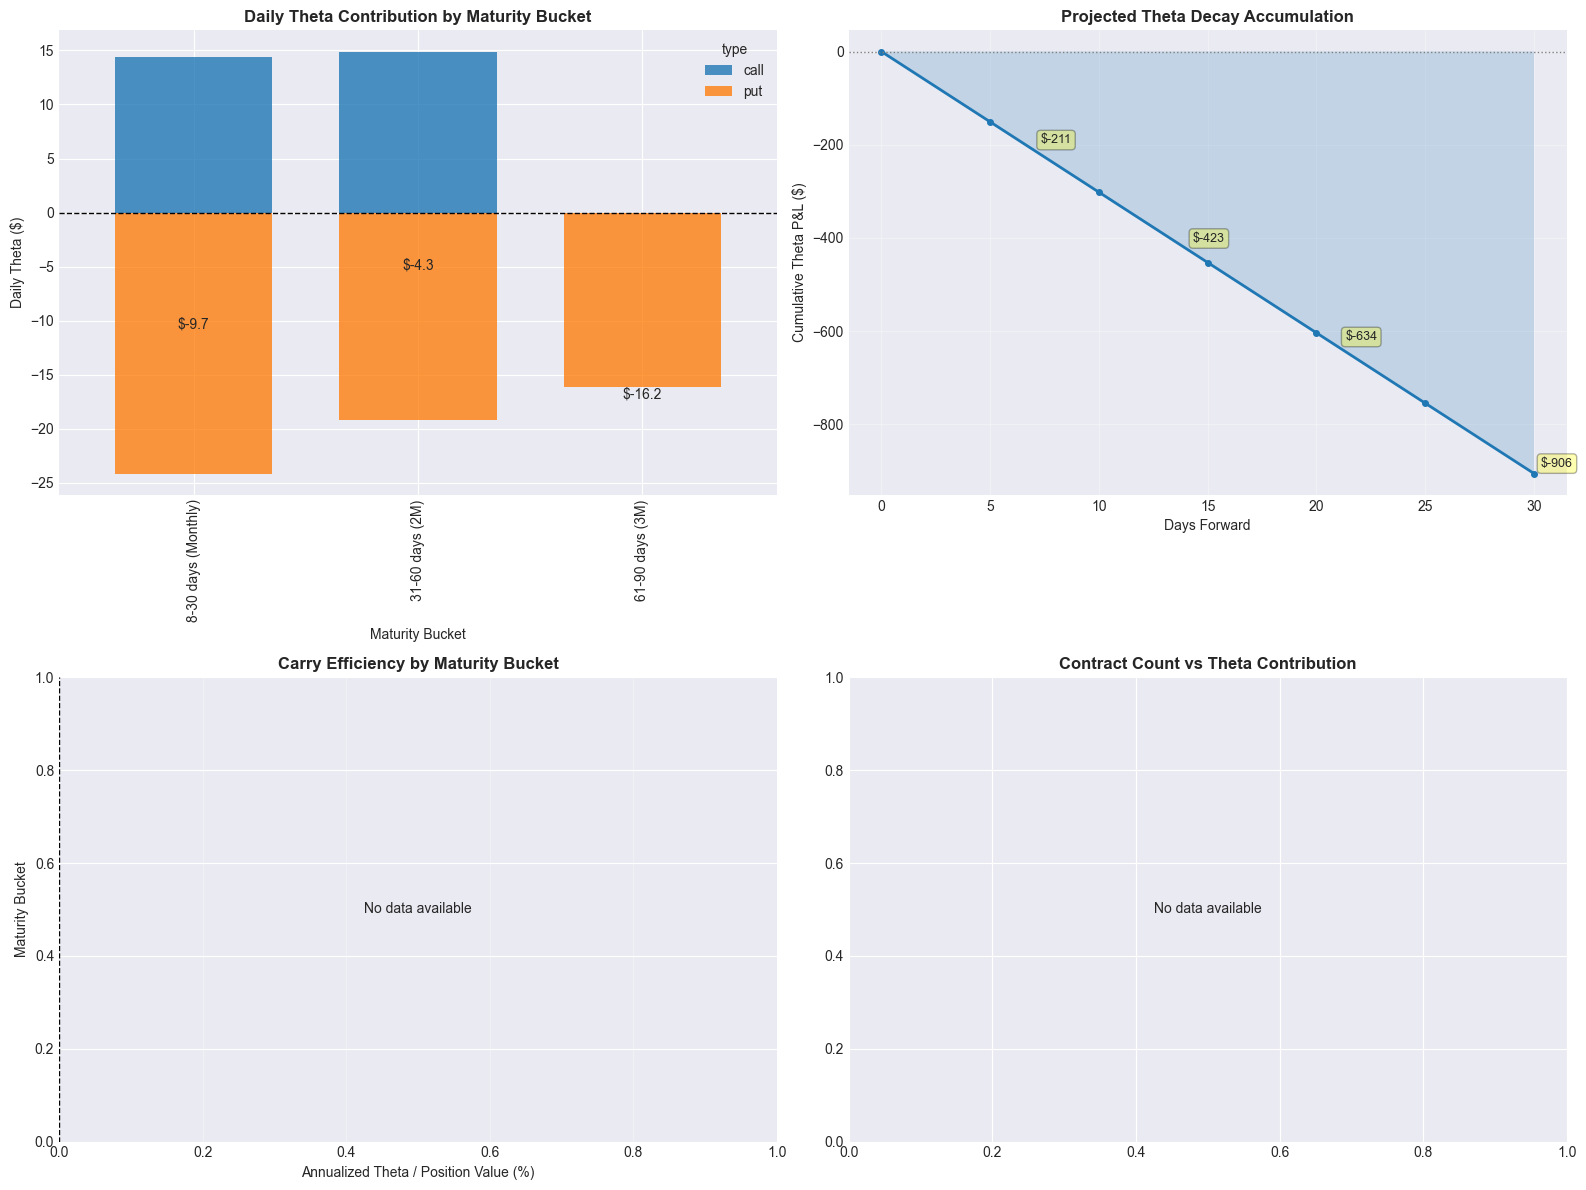


CASHFLOW AND CARRY ANALYSIS

1. OVERALL THETA METRICS:
--------------------------------------------------------------------------------
Daily Theta:     $      -30.19
Weekly Theta:    $     -211.34
Monthly Theta:   $     -905.76
Annual Theta:    $  -11,020.12

⚠ Portfolio is PAYING $30.19 per day for time decay
   (Long options premium erosion)

2. THETA BY MATURITY BUCKET:
--------------------------------------------------------------------------------
Bucket                    Daily Theta     % of Total   Contracts   
--------------------------------------------------------------------------------
8-30 days (Monthly)       $       -9.73       32.2%          14
31-60 days (2M)           $       -4.28       14.2%          14
61-90 days (3M)           $      -16.18       53.6%           8

3. THETA BY POSITION TYPE:
--------------------------------------------------------------------------------
Call       $       29.31   (12 contracts)
Put        $      -59.50   (24 contracts)

4. COV

In [17]:
# Theta Decay Analysis by Maturity Bucket
# Reset to base market conditions
portfolio.update_market_conditions(spot_price=spot_price, volatility=volatility)

# Get current portfolio state
df_carry = df_positions.copy()

# Calculate days to expiry for each position
df_carry['days_to_expiry'] = df_carry['maturity'].apply(
    lambda x: (pd.to_datetime(x) - pd.Timestamp.now()).days
)

# Create maturity buckets
def classify_maturity(days):
    if days <= 7:
        return '0-7 days (Weekly)'
    elif days <= 30:
        return '8-30 days (Monthly)'
    elif days <= 60:
        return '31-60 days (2M)'
    elif days <= 90:
        return '61-90 days (3M)'
    else:
        return '90+ days (Long-term)'

df_carry['maturity_bucket'] = df_carry['days_to_expiry'].apply(classify_maturity)

# Aggregate theta by maturity bucket and type
theta_by_bucket = df_carry.groupby(['maturity_bucket', 'type']).agg({
    'position_theta': 'sum',
    'position_value': 'sum',
    'quantity': lambda x: x.abs().sum()  # Total contracts
}).reset_index()

# Calculate total portfolio theta
total_theta_daily = df_carry['position_theta'].sum()
total_theta_weekly = total_theta_daily * 7
total_theta_monthly = total_theta_daily * 30
total_theta_annual = total_theta_daily * 365

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Theta by Maturity Bucket (Stacked by Type)
ax1 = axes[0, 0]
theta_pivot = theta_by_bucket.pivot_table(
    values='position_theta',
    index='maturity_bucket',
    columns='type',
    aggfunc='sum',
    fill_value=0
)
# Sort by days (custom order)
bucket_order = ['0-7 days (Weekly)', '8-30 days (Monthly)', '31-60 days (2M)', 
                '61-90 days (3M)', '90+ days (Long-term)']
theta_pivot = theta_pivot.reindex([b for b in bucket_order if b in theta_pivot.index])

# Only plot if we have data
if len(theta_pivot) > 0 and len(theta_pivot.columns) > 0:
    theta_pivot.plot(kind='bar', stacked=True, ax=ax1, alpha=0.8, width=0.7)
    ax1.axhline(y=0, color='black', linestyle='--', linewidth=1)
    # Add net theta annotation
    for i, bucket in enumerate(theta_pivot.index):
        net_theta = theta_pivot.loc[bucket].sum()
        ax1.text(i, net_theta, f'${net_theta:.1f}', ha='center', va='bottom' if net_theta > 0 else 'top')
else:
    ax1.text(0.5, 0.5, 'No data available', ha='center', va='center', transform=ax1.transAxes)
ax1.set_xlabel('Maturity Bucket')
ax1.set_ylabel('Daily Theta ($)')
ax1.set_title('Daily Theta Contribution by Maturity Bucket', fontsize=12, fontweight='bold')

# 2. Cumulative Theta Projection (Time Series)
ax2 = axes[0, 1]
projection_days = 30
days_range = np.arange(0, projection_days + 1)
cumulative_theta = days_range * total_theta_daily

ax2.plot(days_range, cumulative_theta, linewidth=2, marker='o', markersize=4, markevery=5)
ax2.axhline(y=0, color='gray', linestyle=':', linewidth=1)
ax2.fill_between(days_range, 0, cumulative_theta, alpha=0.2)
ax2.set_xlabel('Days Forward')
ax2.set_ylabel('Cumulative Theta P&L ($)')
ax2.set_title('Projected Theta Decay Accumulation', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)

# Add milestone annotations
milestones = [7, 14, 21, 30]
for day in milestones:
    if day <= projection_days:
        pnl = day * total_theta_daily
        ax2.annotate(f'${pnl:.0f}', xy=(day, pnl), xytext=(5, 5), 
                    textcoords='offset points', fontsize=9, 
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.3))

# 3. Theta/Value Ratio by Bucket (Carry Efficiency)
ax3 = axes[1, 0]
bucket_summary = df_carry.groupby('maturity_bucket').agg({
    'position_theta': 'sum',
    'position_value': lambda x: x.abs().sum()
}).reset_index()
bucket_summary['theta_pct'] = (bucket_summary['position_theta'] / bucket_summary['position_value']) * 100 * 365
bucket_summary = bucket_summary.set_index('maturity_bucket').reindex([b for b in bucket_order if b in bucket_summary.index])

# Only plot if we have data
if len(bucket_summary) > 0 and not bucket_summary['theta_pct'].isna().all():
    colors = ['green' if x > 0 else 'red' for x in bucket_summary['theta_pct']]
    bucket_summary['theta_pct'].plot(kind='barh', ax=ax3, color=colors, alpha=0.7)
else:
    ax3.text(0.5, 0.5, 'No data available', ha='center', va='center', transform=ax3.transAxes)
ax3.axvline(x=0, color='black', linestyle='--', linewidth=1)
ax3.set_xlabel('Annualized Theta / Position Value (%)')
ax3.set_ylabel('Maturity Bucket')
ax3.set_title('Carry Efficiency by Maturity Bucket', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='x')

# 4. Position Count and Theta Contribution
ax4 = axes[1, 1]
bucket_summary_full = df_carry.groupby('maturity_bucket').agg({
    'position_theta': 'sum',
    'quantity': lambda x: x.abs().sum()
}).reset_index()
bucket_summary_full = bucket_summary_full.set_index('maturity_bucket').reindex([b for b in bucket_order if b in bucket_summary_full.index])

# Only plot if we have data
if len(bucket_summary_full) > 0 and not bucket_summary_full.empty:
    # Create dual-axis plot
    ax4_twin = ax4.twinx()
    bucket_summary_full['quantity'].plot(kind='bar', ax=ax4, color='steelblue', alpha=0.6, width=0.4, position=0, label='Contracts')
    bucket_summary_full['position_theta'].plot(kind='bar', ax=ax4_twin, color='coral', alpha=0.6, width=0.4, position=1, label='Theta')

    ax4.set_xlabel('Maturity Bucket')
    ax4.set_ylabel('Total Contracts', color='steelblue')
    ax4_twin.set_ylabel('Daily Theta ($)', color='coral')
    ax4.set_title('Contract Count vs Theta Contribution', fontsize=12, fontweight='bold')
    ax4.tick_params(axis='x', rotation=45)
    ax4.tick_params(axis='y', labelcolor='steelblue')
    ax4_twin.tick_params(axis='y', labelcolor='coral')
    ax4.grid(True, alpha=0.3, axis='y')

    # Add legends
    ax4.legend(loc='upper left')
    ax4_twin.legend(loc='upper right')
else:
    ax4.text(0.5, 0.5, 'No data available', ha='center', va='center', transform=ax4.transAxes)
    ax4.set_title('Contract Count vs Theta Contribution', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# ============================================================================
# Detailed Theta Summary
# ============================================================================

print("\n" + "=" * 80)
print("CASHFLOW AND CARRY ANALYSIS")
print("=" * 80)

print("\n1. OVERALL THETA METRICS:")
print("-" * 80)
print(f"Daily Theta:     ${total_theta_daily:>12,.2f}")
print(f"Weekly Theta:    ${total_theta_weekly:>12,.2f}")
print(f"Monthly Theta:   ${total_theta_monthly:>12,.2f}")
print(f"Annual Theta:    ${total_theta_annual:>12,.2f}")

if total_theta_daily < 0:
    print(f"\n⚠ Portfolio is PAYING ${-total_theta_daily:.2f} per day for time decay")
    print("   (Long options premium erosion)")
else:
    print(f"\n✓ Portfolio is EARNING ${total_theta_daily:.2f} per day from time decay")
    print("   (Short options premium collection)")

print("\n2. THETA BY MATURITY BUCKET:")
print("-" * 80)
print(f"{'Bucket':<25} {'Daily Theta':<15} {'% of Total':<12} {'Contracts':<12}")
print("-" * 80)

theta_total_abs = df_carry.groupby('maturity_bucket')['position_theta'].sum().abs().sum()
for bucket in bucket_order:
    bucket_data = df_carry[df_carry['maturity_bucket'] == bucket]
    if len(bucket_data) > 0:
        theta_bucket = bucket_data['position_theta'].sum()
        pct_contribution = (abs(theta_bucket) / theta_total_abs * 100) if theta_total_abs > 0 else 0
        contracts = bucket_data['quantity'].abs().sum()
        print(f"{bucket:<25} ${theta_bucket:>12,.2f}   {pct_contribution:>8.1f}%    {contracts:>8.0f}")

print("\n3. THETA BY POSITION TYPE:")
print("-" * 80)
type_theta = df_carry.groupby('type').agg({
    'position_theta': 'sum',
    'quantity': lambda x: x.abs().sum()
})
for opt_type in type_theta.index:
    theta_val = type_theta.loc[opt_type, 'position_theta']
    contracts = type_theta.loc[opt_type, 'quantity']
    print(f"{opt_type.capitalize():<10} ${theta_val:>12,.2f}   ({contracts:.0f} contracts)")

print("\n4. COVERED CALL ANALYSIS:")
print("-" * 80)

# Initialize covered call variables to avoid potential unbound errors
covered_call_theta = 0.0
covered_call_premium = 0.0
num_contracts = 0.0

# Identify short calls (covered call candidates)
short_calls = df_carry[(df_carry['type'] == 'call') & (df_carry['quantity'] < 0)]
if len(short_calls) > 0:
    covered_call_theta = short_calls['position_theta'].sum()
    covered_call_premium = short_calls['position_value'].sum()
    num_contracts = short_calls['quantity'].abs().sum()
    
    print(f"Short Call Positions: {num_contracts:.0f} contracts")
    print(f"Daily Premium Decay:  ${covered_call_theta:,.2f}")
    print(f"Weekly Premium Decay: ${covered_call_theta * 7:,.2f}")
    print(f"Current Premium Value: ${abs(covered_call_premium):,.2f}")
    
    # Calculate days to collect all premium (rough estimate)
    if covered_call_theta > 0:
        days_to_zero = abs(covered_call_premium) / covered_call_theta
        print(f"Days to Full Premium Decay: {days_to_zero:.1f} days")
        print(f"\n✓ Earning ${covered_call_theta:.2f}/day from covered call overlay")
    else:
        print("\n⚠ Short calls are losing value (unusual - check Greeks)")
else:
    print("No short call positions (no covered call overlay detected)")

print("\n5. HEDGE BENEFIT vs THETA COST:")
print("-" * 80)

# Compare hedge benefit (from puts) vs theta cost
# Initialize hedge variables to avoid potential unbound errors
hedge_theta_cost = 0.0
hedge_delta = 0.0
num_hedge_contracts = 0.0

long_puts = df_carry[(df_carry['type'] == 'put') & (df_carry['quantity'] > 0)]
if len(long_puts) > 0:
    hedge_theta_cost = long_puts['position_theta'].sum()
    hedge_delta = long_puts['position_delta'].sum()
    num_hedge_contracts = long_puts['quantity'].sum()
    
    print(f"Long Put Hedge Positions: {num_hedge_contracts:.0f} contracts")
    print(f"Hedge Delta Coverage: {hedge_delta:,.2f}")
    print(f"Daily Theta Cost: ${hedge_theta_cost:,.2f}")
    print(f"Monthly Theta Cost: ${hedge_theta_cost * 30:,.2f}")
    
    # Calculate cost per delta point
    if hedge_delta != 0:
        cost_per_delta = abs(hedge_theta_cost) / abs(hedge_delta)
        print(f"Cost per Delta Point: ${cost_per_delta * 30:.2f}/month")
    
    print(f"\n⚠ Paying ${abs(hedge_theta_cost):.2f}/day for downside protection")
else:
    print("No long put positions (no protective hedge detected)")

# Net theta after hedging
print("\n6. NET CARRY POSITION:")
print("-" * 80)
if len(short_calls) > 0 and len(long_puts) > 0:
    net_theta = covered_call_theta + hedge_theta_cost
    print(f"Premium Collection (Short Calls): ${covered_call_theta:>12,.2f}/day")
    print(f"Hedge Cost (Long Puts):           ${hedge_theta_cost:>12,.2f}/day")
    print(f"{'─' * 60}")
    print(f"Net Daily Carry:                  ${net_theta:>12,.2f}/day")
    print(f"Net Monthly Carry:                ${net_theta * 30:>12,.2f}")
    
    if net_theta > 0:
        print("\n✓ Positive carry: Earning more from calls than paying for puts")
    else:
        print("\n⚠ Negative carry: Hedge costs exceed premium collection")
else:
    print(f"Total Portfolio Theta: ${total_theta_daily:,.2f}/day")

print("\n" + "=" * 80)
print("ACTIONABLE INSIGHTS:")
print("=" * 80)
print("\n• Focus theta management on buckets with highest contribution")
print("• Near-term options (0-30 days) decay fastest - monitor closely")
print("• Covered calls provide income but cap upside - adjust strikes as needed")
print("• Long put hedges cost theta - consider rolling to reduce bleed")
print("• Positive net carry = sustainable income from option overlay")
print("=" * 80)

## 7. Interactive Dashboard

Interactive widgets to explore different market scenarios.

In [18]:
# Create interactive widgets
spot_slider = widgets.FloatSlider(
    value=spot_price,
    min=spot_price * 0.5,
    max=spot_price * 1.5,
    step=0.5,
    description='Spot Price:',
    continuous_update=False
)

vol_slider = widgets.FloatSlider(
    value=volatility,
    min=0.1,
    max=0.5,
    step=0.01,
    description='Volatility:',
    continuous_update=False,
    readout_format='.2f'
)

output_widget = widgets.Output()

def update_dashboard(spot, vol):
    with output_widget:
        output_widget.clear_output(wait=True)
        
        # Update portfolio
        portfolio.update_market_conditions(spot_price=spot, volatility=vol)
        
        # Get updated stats
        stats = portfolio.summary_stats()
        
        # Display summary
        print("UPDATED PORTFOLIO METRICS")
        print("=" * 50)
        print(f"Spot Price: ${spot:.2f} ({(spot/spot_price-1)*100:+.1f}%)")
        print(f"Volatility: {vol:.2%}")
        print()
        print(f"Portfolio Value: ${stats['total_value']:,.2f}")
        print(f"Portfolio Delta: {stats['total_delta']:,.2f}")
        print(f"Net Delta: {stats['net_delta']:,.2f}")
        print(f"Hedge Ratio: {stats['hedge_ratio']:.2f}%")
        print(f"Total Gamma: {stats['total_gamma']:.4f}")
        print(f"Total Vega: {stats['total_vega']:.2f}")
        print(f"Total Theta: ${stats['total_theta']:.2f}/day")
        print("=" * 50)

# Link widgets to update function
interactive_plot = widgets.interactive(
    update_dashboard,
    spot=spot_slider,
    vol=vol_slider
)

display(interactive_plot)
display(output_widget)

interactive(children=(FloatSlider(value=100.0, continuous_update=False, description='Spot Price:', max=150.0, …

Output()

## 8. Hedge Adjustment Recommendations

Calculate and display recommended adjustments to improve the hedge.

In [19]:
# Interactive Hedge Calculator
# Reset portfolio to original market conditions
portfolio.update_market_conditions(spot_price=spot_price, volatility=volatility)
current_stats = portfolio.summary_stats()

# Widgets for hedge target selection
target_hedge_ratio = widgets.FloatSlider(
    value=100.0,
    min=0.0,
    max=200.0,
    step=10.0,
    description='Target Hedge %:',
    style={'description_width': '150px'},
    layout=widgets.Layout(width='500px'),
    continuous_update=False
)

hedge_output = widgets.Output()

def calculate_hedge_actions(target_ratio_pct):
    """Calculate required trades to achieve target hedge ratio."""
    with hedge_output:
        hedge_output.clear_output(wait=True)
        
        # Get current portfolio metrics
        current_delta = current_stats['total_delta']
        notional = current_stats['notional_position']
        current_ratio = current_stats['hedge_ratio']
        
        # Calculate target delta based on desired hedge ratio
        # hedge_ratio = (portfolio_delta / notional) * 100
        # So target_delta = (target_ratio / 100) * notional
        target_delta = (target_ratio_pct / 100.0) * notional
        delta_change_needed = target_delta - current_delta
        
        print("=" * 80)
        print("HEDGE ACTION CALCULATOR")
        print("=" * 80)
        print("\nCurrent State:")
        print(f"  Portfolio Delta: {current_delta:,.2f}")
        print(f"  Notional Position: {notional:,.2f} shares")
        print(f"  Current Hedge Ratio: {current_ratio:.2f}%")
        print("\nTarget State:")
        print(f"  Target Hedge Ratio: {target_ratio_pct:.2f}%")
        print(f"  Target Portfolio Delta: {target_delta:,.2f}")
        print(f"  Delta Change Needed: {delta_change_needed:,.2f}")
        
        print(f"\n{'=' * 80}")
        print("OPTION 1: UNDERLYING SHARE TRADES")
        print(f"{'=' * 80}")
        
        if abs(delta_change_needed) < 1:
            print("✓ No adjustment needed - portfolio already at target hedge ratio")
        elif delta_change_needed > 0:
            print(f"→ BUY {delta_change_needed:,.0f} shares of the underlying")
            print(f"  Cost (approx): ${delta_change_needed * spot_price:,.2f}")
        else:
            print(f"→ SELL {-delta_change_needed:,.0f} shares of the underlying")
            print(f"  Proceeds (approx): ${-delta_change_needed * spot_price:,.2f}")
        
        print(f"\n{'=' * 80}")
        print("OPTION 2: EQUIVALENT OPTION TRADES")
        print(f"{'=' * 80}")
        
        if abs(delta_change_needed) < 1:
            print("✓ No adjustment needed")
        else:
            print("\nOption-based hedge alternatives (sorted by delta effectiveness):\n")
            
            # Build list of option alternatives with their deltas
            option_alternatives = []
            for idx, pos in enumerate(portfolio.positions):
                per_contract_delta = pos.position_delta() / pos.quantity if pos.quantity != 0 else 0
                
                if abs(per_contract_delta) > 0.01:  # Only show meaningful options
                    contracts_needed = delta_change_needed / per_contract_delta
                    option_type = pos.option.option_type.upper()
                    strike = pos.option.strike_price
                    maturity = pos.option.maturity_date.strftime('%Y-%m-%d')
                    price = pos.option.price()
                    
                    option_alternatives.append({
                        'idx': idx,
                        'type': option_type,
                        'strike': strike,
                        'maturity': maturity,
                        'delta_per_contract': per_contract_delta,
                        'contracts_needed': contracts_needed,
                        'price': price,
                        'cost': abs(contracts_needed) * price * 100  # 100 shares per contract
                    })
            
            # Sort by absolute contracts needed (prefer fewer contracts)
            option_alternatives.sort(key=lambda x: abs(x['contracts_needed']))
            
            if not option_alternatives:
                print("⚠ No suitable options found in portfolio for hedging")
            else:
                # Display top alternatives
                print(f"{'Action':<6} {'Type':<6} {'Strike':<8} {'Maturity':<12} {'Delta/Contract':<15} {'Contracts':<10} {'Approx Cost':<15}")
                print("-" * 85)
                
                for alt in option_alternatives[:10]:  # Show top 10
                    action = "BUY" if alt['contracts_needed'] > 0 else "SELL"
                    contracts_abs = abs(alt['contracts_needed'])
                    
                    print(f"{action:<6} {alt['type']:<6} {alt['strike']:<8.2f} {alt['maturity']:<12} "
                          f"{alt['delta_per_contract']:<15.2f} {contracts_abs:<10.1f} "
                          f"${alt['cost']:>13,.2f}")
                
                print("\n" + "-" * 85)
                print("Note: Action shows whether to BUY or SELL the specified number of contracts")
                print("      Cost assumes premium × contracts × 100 (shares per contract)")
                print("      Sorted by fewest contracts needed (most delta-efficient)")
        
        print(f"\n{'=' * 80}")
        print("COMBINED STRATEGY NOTES:")
        print(f"{'=' * 80}")
        print("• Share trades provide exact delta hedging")
        print("• Option trades provide leveraged exposure with gamma/vega effects")
        print("• Consider combining shares + options for capital efficiency")
        print("• Rebalance as market moves to maintain target hedge ratio")
        print(f"{'=' * 80}\n")

# Wire up widget
def on_target_changed(change):
    calculate_hedge_actions(change['new'])

target_hedge_ratio.observe(on_target_changed, names='value')

# Display hedge calculator
display(widgets.VBox([
    widgets.HTML("<h3>Interactive Hedge Calculator</h3>"),
    widgets.HTML("<p>Adjust target hedge ratio to see required trades (0% = no hedge, 100% = fully hedged, 200% = 2x hedged)</p>"),
    target_hedge_ratio,
    hedge_output
]))

# Initial calculation
calculate_hedge_actions(target_hedge_ratio.value)

In [20]:
# VERIFICATION: Test hedge calculator logic
print("=" * 80)
print("HEDGE CALCULATOR VERIFICATION TESTS")
print("=" * 80)

# Get current portfolio state
test_stats = portfolio.summary_stats()
print("\nCurrent Portfolio State:")
print(f"  Portfolio Delta: {test_stats['total_delta']:,.2f}")
print(f"  Notional Position: {test_stats['notional_position']:,.2f}")
print(f"  Current Hedge Ratio: {test_stats['hedge_ratio']:.2f}%")

# Test 1: Verify a specific position's delta contribution
if len(portfolio.positions) > 0:
    print("\n" + "=" * 80)
    print("TEST 1: Individual Position Delta Verification")
    print("=" * 80)
    
    test_pos = portfolio.positions[0]
    pos_delta = test_pos.position_delta()
    per_contract = pos_delta / test_pos.quantity if test_pos.quantity != 0 else 0
    
    print(f"\nPosition 0: {test_pos.option.option_type.upper()} K={test_pos.option.strike_price}")
    print(f"  Quantity: {test_pos.quantity}")
    print(f"  Total Position Delta: {pos_delta:.2f}")
    print(f"  Delta per Contract: {per_contract:.4f}")
    print(f"  Option Delta (single): {test_pos.option.delta():.4f}")
    print(f"  Expected per contract: {test_pos.option.delta() * 100:.2f} (option delta × 100 shares)")
    
    # Verify the math
    expected_position_delta = test_pos.option.delta() * 100 * test_pos.quantity
    print(f"\nVerification: {expected_position_delta:.2f} (calculated) vs {pos_delta:.2f} (method)")
    if abs(expected_position_delta - pos_delta) < 0.01:
        print("  ✓ Position delta calculation CORRECT")
    else:
        print("  ✗ Position delta calculation MISMATCH")

# Test 2: Verify hedge action logic
print("\n" + "=" * 80)
print("TEST 2: Hedge Action Logic Verification")
print("=" * 80)

test_scenarios = [
    {"name": "Need +100 delta", "delta_change": 100, "pos_delta_per_contract": 50},
    {"name": "Need +100 delta", "delta_change": 100, "pos_delta_per_contract": -50},
    {"name": "Need -100 delta", "delta_change": -100, "pos_delta_per_contract": 50},
    {"name": "Need -100 delta", "delta_change": -100, "pos_delta_per_contract": -50},
]

print("\nScenario Tests:")
for scenario in test_scenarios:
    contracts = scenario['delta_change'] / scenario['pos_delta_per_contract']
    action = "BUY" if contracts > 0 else "SELL"
    option_type = "CALL" if scenario['pos_delta_per_contract'] > 0 else "PUT"
    
    print(f"\n  {scenario['name']}, {option_type} with delta {scenario['pos_delta_per_contract']:+.2f}/contract:")
    print(f"    → {action} {abs(contracts):.1f} contracts")
    print(f"    → Delta added: {contracts * scenario['pos_delta_per_contract']:+.2f}")
    
    # Verify the delta math
    actual_delta = contracts * scenario['pos_delta_per_contract']
    if abs(actual_delta - scenario['delta_change']) < 0.01:
        print(f"    ✓ Correct: adds {actual_delta:+.2f} delta")
    else:
        print(f"    ✗ Wrong: adds {actual_delta:+.2f} instead of {scenario['delta_change']:+.2f}")

# Test 3: Verify target hedge ratio calculation
print("\n" + "=" * 80)
print("TEST 3: Target Hedge Ratio Calculation")
print("=" * 80)

for target_pct in [0, 50, 100, 150, 200]:
    target_delta = (target_pct / 100.0) * test_stats['notional_position']
    delta_needed = target_delta - test_stats['total_delta']
    
    print(f"\nTarget {target_pct}% hedge:")
    print(f"  Target Delta: {target_delta:,.2f}")
    print(f"  Current Delta: {test_stats['total_delta']:,.2f}")
    print(f"  Change Needed: {delta_needed:+,.2f}")
    print(f"  Share Action: {'BUY' if delta_needed > 0 else 'SELL'} {abs(delta_needed):,.0f} shares")

print("\n" + "=" * 80)
print("✓ All verification tests complete")
print("=" * 80)

HEDGE CALCULATOR VERIFICATION TESTS

Current Portfolio State:
  Portfolio Delta: -895.25
  Notional Position: 1,000.00
  Current Hedge Ratio: 89.53%

TEST 1: Individual Position Delta Verification

Position 0: PUT K=90.0
  Quantity: 3
  Total Position Delta: -18.56
  Delta per Contract: -6.1866
  Option Delta (single): -0.0619
  Expected per contract: -6.19 (option delta × 100 shares)

Verification: -18.56 (calculated) vs -18.56 (method)
  ✓ Position delta calculation CORRECT

TEST 2: Hedge Action Logic Verification

Scenario Tests:

  Need +100 delta, CALL with delta +50.00/contract:
    → BUY 2.0 contracts
    → Delta added: +100.00
    ✓ Correct: adds +100.00 delta

  Need +100 delta, PUT with delta -50.00/contract:
    → SELL 2.0 contracts
    → Delta added: +100.00
    ✓ Correct: adds +100.00 delta

  Need -100 delta, CALL with delta +50.00/contract:
    → SELL 2.0 contracts
    → Delta added: -100.00
    ✓ Correct: adds -100.00 delta

  Need -100 delta, PUT with delta -50.00/cont

## 9. Time vs Price P&L Heat Map

Visualize portfolio profit/loss across different time horizons and underlying price levels.

This analysis shows:
- **X-axis**: Time progression (weekly or monthly, up to 2 years or last expiry)
- **Y-axis**: Underlying price scenarios
- **Values**: Net P&L in dollars or percentage terms

In [21]:
from datetime import timedelta

# Determine time horizon
last_expiry = max([pos.option.maturity_date for pos in portfolio.positions])
time_to_last_expiry = (last_expiry - today).days
max_horizon_days = max(730, time_to_last_expiry)  # 2 years or last expiry, whichever is longer

# Determine if weekly or monthly (max 24 time points)
if max_horizon_days / 7 <= 24:
    time_freq = 'weekly'
    time_step_days = 7
    num_periods = min(24, max_horizon_days // 7)
else:
    time_freq = 'monthly'
    time_step_days = 30
    num_periods = min(24, max_horizon_days // 30)

# Generate time points
time_points = [today + timedelta(days=i * time_step_days) for i in range(num_periods + 1)]
time_labels = [f"{(t - today).days}d" for t in time_points]

print("Time Analysis Setup:")
print(f"  Frequency: {time_freq.capitalize()}")
print(f"  Number of periods: {num_periods + 1}")
print(f"  Time horizon: {max_horizon_days} days")
print(f"  Last option expiry: {last_expiry.strftime('%Y-%m-%d')}")

Time Analysis Setup:
  Frequency: Monthly
  Number of periods: 25
  Time horizon: 730 days
  Last option expiry: 2026-03-20


In [22]:
# Interactive widgets for P&L heat map
price_range_slider = widgets.FloatSlider(
    value=20.0,
    min=5.0,
    max=50.0,
    step=5.0,
    description='Price Range (%):',
    style={'description_width': '150px'},
    layout=widgets.Layout(width='500px')
)

display_format = widgets.Dropdown(
    options=[('Dollar ($)', 'dollar'), ('Percentage (%)', 'percent')],
    value='dollar',
    description='Display Format:',
    style={'description_width': '150px'}
)

def create_pnl_heatmap(price_range_pct, display_type):
    """Generate P&L heat map across time and price scenarios"""
    
    # Generate price scenarios (10 above, 10 below current spot)
    price_step = (price_range_pct / 100) * spot_price / 10
    price_scenarios = [spot_price + (i - 10) * price_step for i in range(21)]
    
    # Initialize P&L matrix
    pnl_matrix = []
    
    # Calculate P&L for each (time, price) combination
    for future_spot in price_scenarios:
        pnl_row = []
        for future_date in time_points:
            # Calculate portfolio value at this scenario
            portfolio_value = 0
            
            for position in portfolio.positions:
                days_to_maturity = (position.option.maturity_date - future_date).days
                
                if days_to_maturity <= 0:
                    # Option expired - use intrinsic value as final settlement
                    # Multiply by contract_size to get total position value (e.g., 100 shares per contract)
                    if position.option.option_type == 'call':
                        intrinsic = max(0, future_spot - position.option.strike_price)
                    else:
                        intrinsic = max(0, position.option.strike_price - future_spot)
                    portfolio_value += intrinsic * position.quantity * position.contract_size
                else:
                    # Option still alive - recalculate value with time decay
                    # Use valuation_date=future_date to properly model time decay
                    maturity_date = future_date + timedelta(days=days_to_maturity)
                    from deltadewa import AmericanOption
                    
                    opt = AmericanOption(
                        spot_price=future_spot,
                        strike_price=position.option.strike_price,
                        maturity_date=maturity_date,
                        volatility=volatility,
                        risk_free_rate=risk_free_rate,
                        dividend_yield=dividend_yield,
                        option_type=position.option.option_type,
                        valuation_date=future_date
                    )
                    # Multiply by contract_size for total position value
                    portfolio_value += opt.price() * position.quantity * position.contract_size
            
            # Calculate notional position value change
            notional_pnl = notional_position * (future_spot - spot_price)
            
            # Net P&L
            net_pnl = portfolio_value - stats['total_value'] + notional_pnl
            
            if display_type == 'percent':
                # P&L as percentage of initial portfolio value
                initial_value = abs(stats['total_value']) if stats['total_value'] != 0 else abs(notional_position * spot_price)
                net_pnl = (net_pnl / initial_value) * 100 if initial_value != 0 else 0
            
            pnl_row.append(net_pnl)
        pnl_matrix.append(pnl_row)
    
    # Create DataFrame
    df_pnl = pd.DataFrame(
        pnl_matrix,
        index=[f"${p:.2f}" for p in price_scenarios],
        columns=time_labels
    )
    
    # Display as styled heatmap
    if display_type == 'dollar':
        styled = df_pnl.style.background_gradient(cmap='RdYlGn', axis=None)\
                            .format('${:.0f}')\
                            .set_caption(f'Portfolio P&L Heat Map - Dollar Terms (Price Range: ±{price_range_pct}%)')
    else:
        styled = df_pnl.style.background_gradient(cmap='RdYlGn', axis=None)\
                            .format('{:.1f}%')\
                            .set_caption(f'Portfolio P&L Heat Map - Percentage Terms (Price Range: ±{price_range_pct}%)')
    
    display(styled)
    
    # Summary statistics
    print("\nHeat Map Summary:")
    print(f"  Best Case P&L: {df_pnl.max().max():,.2f}" + (' $' if display_type == 'dollar' else '%'))
    print(f"  Worst Case P&L: {df_pnl.min().min():,.2f}" + (' $' if display_type == 'dollar' else '%'))
    print(f"  Average P&L: {df_pnl.mean().mean():,.2f}" + (' $' if display_type == 'dollar' else '%'))

# Create interactive widget
pnl_output = widgets.Output()

def update_heatmap(change):
    with pnl_output:
        pnl_output.clear_output(wait=True)
        create_pnl_heatmap(price_range_slider.value, display_format.value)

price_range_slider.observe(update_heatmap, 'value')
display_format.observe(update_heatmap, 'value')

# Display controls
display(widgets.VBox([
    widgets.HBox([price_range_slider, display_format]),
    pnl_output
]))

# Initial display
with pnl_output:
    create_pnl_heatmap(price_range_slider.value, display_format.value)

In [23]:
# Reset to original market conditions
portfolio.update_market_conditions(
    spot_price=spot_price,
    volatility=volatility
)

stats = portfolio.summary_stats()

print("HEDGE ADJUSTMENT RECOMMENDATIONS")
print("=" * 70)
print(f"\nCurrent Net Delta: {stats['net_delta']:,.2f}")
print(f"Current Hedge Ratio: {stats['hedge_ratio']:.2f}%")

# Recommendation 1: Delta Neutral
print("\n1. TO ACHIEVE DELTA NEUTRALITY:")
delta_adj = stats['delta_adjustment']
if abs(delta_adj) < 1:
    print("   ✓ Portfolio is approximately delta neutral")
elif delta_adj > 0:
    print(f"   → BUY {delta_adj:.0f} shares of the underlying")
else:
    print(f"   → SELL {-delta_adj:.0f} shares of the underlying")

# Recommendation 2: Gamma exposure
print("\n2. GAMMA EXPOSURE:")
if stats['total_gamma'] > 0:
    print(f"   Current Gamma: {stats['total_gamma']:.4f} (POSITIVE)")
    print("   → Portfolio will become more long as spot increases")
    print("   → Portfolio will become more short as spot decreases")
else:
    print(f"   Current Gamma: {stats['total_gamma']:.4f} (NEGATIVE)")
    print("   → Portfolio will become more short as spot increases")
    print("   → Portfolio will become more long as spot decreases")

# Recommendation 3: Theta (time decay)
print("\n3. TIME DECAY (THETA):")
annual_theta = stats['total_theta'] * 365
if stats['total_theta'] < 0:
    print(f"   Daily Theta: ${stats['total_theta']:.2f}")
    print(f"   Annualized: ${annual_theta:.2f}")
    print("   → Portfolio loses value over time (typical for long options)")
    print("   → Consider rolling positions or reducing quantity")
else:
    print(f"   Daily Theta: ${stats['total_theta']:.2f}")
    print(f"   Annualized: ${annual_theta:.2f}")
    print("   → Portfolio gains value over time (typical for short options)")

# Recommendation 4: Vega exposure
print("\n4. VOLATILITY EXPOSURE (VEGA):")
print(f"   Total Vega: {stats['total_vega']:.2f}")
if stats['total_vega'] > 0:
    print("   → Portfolio benefits from volatility increase")
    print("   → Portfolio loses value if volatility decreases")
else:
    print("   → Portfolio benefits from volatility decrease")
    print("   → Portfolio loses value if volatility increases")

print("\n" + "=" * 70)

HEDGE ADJUSTMENT RECOMMENDATIONS

Current Net Delta: 104.75
Current Hedge Ratio: 89.53%

1. TO ACHIEVE DELTA NEUTRALITY:
   → SELL 105 shares of the underlying

2. GAMMA EXPOSURE:
   Current Gamma: 44.2053 (POSITIVE)
   → Portfolio will become more long as spot increases
   → Portfolio will become more short as spot decreases

3. TIME DECAY (THETA):
   Daily Theta: $-30.19
   Annualized: $-11020.12
   → Portfolio loses value over time (typical for long options)
   → Consider rolling positions or reducing quantity

4. VOLATILITY EXPOSURE (VEGA):
   Total Vega: 192.04
   → Portfolio benefits from volatility increase
   → Portfolio loses value if volatility decreases



# 10. Transaction Cost & Roll Analysis

Analyze the impact of slippage and transaction costs on roll decisions and portfolio adjustments.

This analysis includes:
- **Slippage Modeling**: Entry/exit price adjustments based on market impact
- **Transaction Costs**: Commissions and fees per contract
- **Breakeven Analysis**: Required underlying move to overcome transaction costs
- **Roll Decision Economics**: Net cost/credit after all fees and slippage

In [24]:
# Transaction Cost Parameters Widget
slippage_bps_widget = widgets.IntSlider(
    value=10,
    min=0,
    max=100,
    step=5,
    description='Slippage (bps):',
    style={'description_width': '150px'},
    layout=widgets.Layout(width='500px'),
    continuous_update=False
)

commission_per_contract_widget = widgets.FloatText(
    value=0.65,
    min=0.0,
    max=10.0,
    step=0.05,
    description='Commission/Contract:',
    style={'description_width': '150px'},
    layout=widgets.Layout(width='300px')
)

roll_position_selector = widgets.Dropdown(
    options=['Select Position...'] + [
        f"{i}: {p.option.option_type.upper()} K={p.option.strike_price} "
        f"Exp={p.option.maturity_date.strftime('%Y-%m-%d')} Qty={p.quantity}"
        for i, p in enumerate(portfolio.positions)
    ],
    value='Select Position...',
    description='Position to Roll:',
    style={'description_width': '150px'},
    layout=widgets.Layout(width='700px')
)

roll_type = widgets.RadioButtons(
    options=[
        ('Extend Maturity (Same Strike)', 'time'),
        ('Adjust Strike (Same Maturity)', 'strike'),
        ('Both Strike & Maturity', 'both')
    ],
    value='time',
    description='Roll Type:',
    style={'description_width': '150px'}
)

new_strike_input = widgets.FloatText(
    value=100.0,
    description='New Strike:',
    style={'description_width': '150px'},
    layout=widgets.Layout(width='300px')
)

new_maturity_date = widgets.DatePicker(
    description='New Maturity:',
    value=datetime.now().date() + timedelta(days=30),
    style={'description_width': '150px'},
    layout=widgets.Layout(width='400px')
)

roll_output = widgets.Output()

# Display transaction cost controls
display(widgets.VBox([
    widgets.HTML("<h3>Transaction Cost Parameters</h3>"),
    widgets.HTML("<p>Model slippage and commissions to understand true cost of portfolio adjustments</p>"),
    widgets.HBox([slippage_bps_widget, commission_per_contract_widget]),
]))

print("\n" + "=" * 80)
print("Transaction Cost Modeling Setup Complete")
print("=" * 80)
print("\nCurrent Settings:")
print(f"  Slippage: {slippage_bps_widget.value} basis points")
print(f"  Commission: ${commission_per_contract_widget.value} per contract")
print(f"\n{'=' * 80}")


Transaction Cost Modeling Setup Complete

Current Settings:
  Slippage: 10 basis points
  Commission: $0.65 per contract



In [25]:
def calculate_transaction_costs(option_price, num_contracts, slippage_bps, commission_per_contract):
    """
    Calculate total transaction costs including slippage and commissions.
    
    Args:
        option_price: Premium per share (e.g., $5.25)
        num_contracts: Number of contracts being traded
        slippage_bps: Slippage in basis points (e.g., 10 bps = 0.10%)
        commission_per_contract: Commission per contract
    
    Returns:
        dict with breakdown of costs
    """
    if num_contracts == 0:
        return {
            'contract_value': 0.0,
            'total_notional': 0.0,
            'slippage_cost': 0.0,
            'commission_cost': 0.0,
            'total_cost': 0.0,
            'price_adjustment_per_share': 0.0,
            'effective_price': option_price,
        }

    # Contract value (100 shares per contract)
    contract_value = option_price * 100
    total_contract_value = contract_value * abs(num_contracts)
    
    # Slippage cost (as percentage of notional)
    slippage_pct = slippage_bps / 10000.0  # Convert bps to decimal
    slippage_cost = total_contract_value * slippage_pct
    
    # Commission cost
    commission_cost = abs(num_contracts) * commission_per_contract
    
    # Total transaction cost
    total_cost = slippage_cost + commission_cost
    
    # Effective price adjustment per share
    price_adjustment_per_share = total_cost / (abs(num_contracts) * 100)
    
    return {
        'contract_value': contract_value,
        'total_notional': total_contract_value,
        'slippage_cost': slippage_cost,
        'commission_cost': commission_cost,
        'total_cost': total_cost,
        'price_adjustment_per_share': price_adjustment_per_share,
        'effective_price': option_price + price_adjustment_per_share if num_contracts > 0 else option_price - price_adjustment_per_share
    }


def analyze_roll_with_costs(position_idx, new_strike=None, new_maturity=None, slippage_bps=10, commission=0.65):
    """
    Analyze the economics of rolling a position with transaction costs.
    
    Args:
        position_idx: Index of position to roll
        new_strike: New strike price (None = keep same)
        new_maturity: New maturity date (None = keep same)
        slippage_bps: Slippage in basis points
        commission: Commission per contract
    
    Returns:
        dict with detailed roll analysis
    """
    if position_idx >= len(portfolio.positions):
        return None
    
    # Sign convention: quantity > 0 means long contracts, quantity < 0 means short
    old_position = portfolio.positions[position_idx]
    old_option = old_position.option
    quantity = old_position.quantity
    
    # Determine new option parameters
    new_strike = new_strike if new_strike is not None else old_option.strike_price
    new_maturity = new_maturity if new_maturity is not None else old_option.maturity_date
    
    # Create new option
    from deltadewa import AmericanOption
    new_option = AmericanOption(
        spot_price=spot_price,
        strike_price=new_strike,
        maturity_date=new_maturity,
        volatility=volatility,
        risk_free_rate=risk_free_rate,
        dividend_yield=dividend_yield,
        option_type=old_option.option_type,
        valuation_date=portfolio.valuation_date
    )
    
    # Price both options
    old_price = old_option.price()
    new_price = new_option.price()
    
    # Calculate costs for closing old position
    close_costs = calculate_transaction_costs(
        old_price, 
        quantity,  # Same sign as position (selling if long, buying if short)
        slippage_bps, 
        commission
    )
    
    # Calculate costs for opening new position
    open_costs = calculate_transaction_costs(
        new_price,
        quantity,
        slippage_bps,
        commission
    )
    
    # Net premium exchange (excluding costs)
    if quantity > 0:  # Long position: sell old, buy new
        premium_exchange = (old_price - new_price) * abs(quantity) * 100
    else:  # Short position: buy old, sell new
        premium_exchange = (new_price - old_price) * abs(quantity) * 100
    
    # Total transaction costs
    total_tx_costs = close_costs['total_cost'] + open_costs['total_cost']
    
    # Net cost/credit of roll
    net_cost = -premium_exchange + total_tx_costs  # Positive = costs money, negative = earns credit
    
    # Calculate greeks for both positions
    old_delta = old_option.delta() * 100 * quantity
    new_delta = new_option.delta() * 100 * quantity
    delta_change = new_delta - old_delta
    
    old_theta = old_option.theta() * 100 * quantity
    new_theta = new_option.theta() * 100 * quantity
    theta_change = new_theta - old_theta
    
    old_vega = old_option.vega() * 100 * quantity
    new_vega = new_option.vega() * 100 * quantity
    vega_change = new_vega - old_vega
    
    # Breakeven analysis
    # How much does underlying need to move to overcome net cost?
    # Using delta as sensitivity
    if abs(new_delta) > 0.01:
        breakeven_move = net_cost / abs(new_delta)
        breakeven_pct = (breakeven_move / spot_price) * 100
    else:
        breakeven_move = float('inf')
        breakeven_pct = float('inf')
    
    # Days to recover costs via theta (if theta is positive)
    if new_theta > 0:
        days_to_recover = net_cost / new_theta
    else:
        days_to_recover = float('inf')
    
    return {
        'old_option': {
            'type': old_option.option_type,
            'strike': old_option.strike_price,
            'maturity': old_option.maturity_date,
            'price': old_price,
            'delta': old_delta,
            'theta': old_theta,
            'vega': old_vega
        },
        'new_option': {
            'type': new_option.option_type,
            'strike': new_strike,
            'maturity': new_maturity,
            'price': new_price,
            'delta': new_delta,
            'theta': new_theta,
            'vega': new_vega
        },
        'costs': {
            'close_slippage': close_costs['slippage_cost'],
            'close_commission': close_costs['commission_cost'],
            'close_total': close_costs['total_cost'],
            'open_slippage': open_costs['slippage_cost'],
            'open_commission': open_costs['commission_cost'],
            'open_total': open_costs['total_cost'],
            'total_tx_costs': total_tx_costs
        },
        'economics': {
            'premium_exchange': premium_exchange,
            'net_cost': net_cost,
            'delta_change': delta_change,
            'theta_change': theta_change,
            'vega_change': vega_change,
            'breakeven_move': breakeven_move,
            'breakeven_pct': breakeven_pct,
            'days_to_recover': days_to_recover
        },
        'quantity': quantity
    }


# Test the calculation
print("Transaction Cost Functions Loaded")
print("\nExample: Cost of trading 10 contracts at $5.25 premium")
print("=" * 70)

example_costs = calculate_transaction_costs(5.25, 10, 10, 0.65)
print(f"Total Notional: ${example_costs['total_notional']:,.2f}")
print(f"Slippage Cost: ${example_costs['slippage_cost']:.2f}")
print(f"Commission Cost: ${example_costs['commission_cost']:.2f}")
print(f"Total Transaction Cost: ${example_costs['total_cost']:.2f}")
print(f"Effective Price: ${example_costs['effective_price']:.4f} per share")
print(f"Price Adjustment: ${example_costs['price_adjustment_per_share']:.4f} per share")

Transaction Cost Functions Loaded

Example: Cost of trading 10 contracts at $5.25 premium
Total Notional: $5,250.00
Slippage Cost: $5.25
Commission Cost: $6.50
Total Transaction Cost: $11.75
Effective Price: $5.2618 per share
Price Adjustment: $0.0118 per share


In [26]:
# Interactive Roll Analyzer with Transaction Costs
def display_roll_analysis(change=None):
    """Display comprehensive roll analysis with transaction costs."""
    with roll_output:
        roll_output.clear_output(wait=True)
        
        # Get selected position
        selection = roll_position_selector.value
        if selection == 'Select Position...':
            print("Please select a position to analyze")
            return
        
        # Extract position index
        position_idx = int(selection.split(':')[0])
        
        # Get parameters
        slippage = slippage_bps_widget.value
        commission = commission_per_contract_widget.value
        roll_strategy = roll_type.value
        
        # Determine new strike and maturity based on roll type
        old_pos = portfolio.positions[position_idx]
        
        if roll_strategy == 'time':
            new_strike = old_pos.option.strike_price
            new_mat = new_maturity_date.value
        elif roll_strategy == 'strike':
            new_strike = new_strike_input.value
            new_mat = old_pos.option.maturity_date
        else:  # both
            new_strike = new_strike_input.value
            new_mat = new_maturity_date.value
        
        # Convert date to datetime
        if isinstance(new_mat, datetime):
            new_mat_dt = new_mat
        else:
            new_mat_dt = datetime.combine(new_mat, datetime.min.time())
        
        # Analyze roll
        analysis = analyze_roll_with_costs(
            position_idx,
            new_strike=new_strike,
            new_maturity=new_mat_dt,
            slippage_bps=slippage,
            commission=commission
        )
        
        if analysis is None:
            print("Invalid position index")
            return
        
        # Display results
        print("=" * 90)
        print("ROLL ANALYSIS WITH TRANSACTION COSTS")
        print("=" * 90)
        
        print("\n📋 POSITION DETAILS:")
        print(f"  Quantity: {analysis['quantity']} contracts")
        print(f"  Position Type: {'LONG' if analysis['quantity'] > 0 else 'SHORT'}")
        
        print("\n🔴 CLOSING OLD POSITION:")
        old = analysis['old_option']
        print(f"  {old['type'].upper()} Strike: ${old['strike']:.2f}")
        print(f"  Maturity: {old['maturity'].strftime('%Y-%m-%d')}")
        print(f"  Current Price: ${old['price']:.4f} per share")
        print(f"  Delta: {old['delta']:.2f} | Theta: ${old['theta']:.2f}/day | Vega: {old['vega']:.2f}")
        
        print("\n🟢 OPENING NEW POSITION:")
        new = analysis['new_option']
        print(f"  {new['type'].upper()} Strike: ${new['strike']:.2f}")
        print(f"  Maturity: {new['maturity'].strftime('%Y-%m-%d')}")
        print(f"  Current Price: ${new['price']:.4f} per share")
        print(f"  Delta: {new['delta']:.2f} | Theta: ${new['theta']:.2f}/day | Vega: {new['vega']:.2f}")
        
        print("\n💰 TRANSACTION COSTS BREAKDOWN:")
        costs = analysis['costs']
        print("  Close Old Position:")
        print(f"    • Slippage: ${costs['close_slippage']:.2f}")
        print(f"    • Commission: ${costs['close_commission']:.2f}")
        print(f"    • Subtotal: ${costs['close_total']:.2f}")
        print("  Open New Position:")
        print(f"    • Slippage: ${costs['open_slippage']:.2f}")
        print(f"    • Commission: ${costs['open_commission']:.2f}")
        print(f"    • Subtotal: ${costs['open_total']:.2f}")
        print(f"  {'─' * 50}")
        print(f"  TOTAL TRANSACTION COSTS: ${costs['total_tx_costs']:.2f}")
        
        print("\n📊 ROLL ECONOMICS:")
        econ = analysis['economics']
        print(f"  Premium Exchange: ${econ['premium_exchange']:+,.2f}")
        print(f"  Transaction Costs: ${costs['total_tx_costs']:,.2f}")
        print(f"  {'─' * 50}")
        
        if econ['net_cost'] > 0:
            print(f"  NET COST OF ROLL: ${econ['net_cost']:,.2f} (DEBIT)")
        elif econ['net_cost'] < 0:
            print(f"  NET CREDIT FROM ROLL: ${-econ['net_cost']:,.2f} (CREDIT)")
        else:
            print("  NET COST OF ROLL: $0.00 (EVEN)")
        
        print("\n📈 GREEKS CHANGES:")
        print(f"  Delta Change: {econ['delta_change']:+.2f}")
        print(f"  Theta Change: ${econ['theta_change']:+.2f} per day")
        print(f"  Vega Change: {econ['vega_change']:+.2f}")
        
        print("\n🎯 BREAKEVEN ANALYSIS:")
        if abs(econ['breakeven_move']) < 1000:
            print(f"  Required Underlying Move: ${econ['breakeven_move']:+.2f} ({econ['breakeven_pct']:+.2f}%)")
            print(f"  Breakeven Price: ${spot_price + econ['breakeven_move']:.2f}")
            
            if analysis['quantity'] > 0:  # Long position
                if new['type'] == 'call':
                    direction = "UP" if econ['net_cost'] > 0 else "DOWN"
                else:  # put
                    direction = "DOWN" if econ['net_cost'] > 0 else "UP"
            else:  # Short position
                if new['type'] == 'call':
                    direction = "DOWN" if econ['net_cost'] > 0 else "UP"
                else:  # put
                    direction = "UP" if econ['net_cost'] > 0 else "DOWN"
            
            print(f"  Direction: Underlying must move {direction} to overcome costs")
        else:
            print("  Breakeven: Not applicable (very low delta)")
        
        if econ['days_to_recover'] < 1000:
            print("\n⏱️  THETA RECOVERY:")
            print(f"  Days to recover costs via theta: {econ['days_to_recover']:.1f} days")
            if econ['days_to_recover'] < (new['maturity'] - today).days:
                print(f"  ✓ Recoverable before expiry ({(new['maturity'] - today).days} days left)")
            else:
                print(f"  ⚠️  Exceeds time to expiry ({(new['maturity'] - today).days} days left)")
        
        print("\n" + "=" * 90)
        
        # Decision guidance
        print("\n💡 DECISION GUIDANCE:")
        
        if econ['net_cost'] < 0:
            print("  ✓ Roll collects a NET CREDIT - economically favorable")
        else:
            print("  ⚠️  Roll requires NET DEBIT - consider alternatives:")
            
        if abs(econ['theta_change']) > abs(costs['total_tx_costs'] / 30):
            print("  ✓ Theta improvement is significant relative to costs")
        
        if abs(econ['breakeven_move']) < spot_price * 0.02:  # Less than 2% move needed
            print("  ⚠️  Breakeven requires small move - costs are material relative to delta")
        
        print("\n" + "=" * 90)


# Wire up widgets
roll_position_selector.observe(display_roll_analysis, 'value')
roll_type.observe(display_roll_analysis, 'value')
slippage_bps_widget.observe(display_roll_analysis, 'value')
commission_per_contract_widget.observe(display_roll_analysis, 'value')

# Display interactive roll analyzer
display(widgets.VBox([
    widgets.HTML("<h3>Interactive Roll Analyzer</h3>"),
    widgets.HTML("<p>Select a position and configure the roll to see detailed cost analysis</p>"),
    roll_position_selector,
    roll_type,
    widgets.HBox([new_strike_input, new_maturity_date]),
    roll_output
]))

# Trigger initial display
display_roll_analysis()

In [27]:
# Portfolio-Level Transaction Cost Impact Analysis
def analyze_portfolio_adjustment_costs(target_hedge_ratio, slippage_bps, commission_per_contract):
    """
    Analyze the cost of adjusting portfolio to a target hedge ratio using options.
    """
    current_stats = portfolio.summary_stats()
    current_delta = current_stats['total_delta']
    notional = current_stats['notional_position']
    
    # Calculate required delta change
    target_delta = (target_hedge_ratio / 100.0) * notional
    delta_needed = target_delta - current_delta
    
    if abs(delta_needed) < 1:
        return None
    
    # Find most efficient options for hedging
    hedge_options = []
    
    for idx, pos in enumerate(portfolio.positions):
        delta_per_contract = pos.position_delta() / pos.quantity if pos.quantity != 0 else 0
        
        if abs(delta_per_contract) > 0.01:
            contracts_needed = delta_needed / delta_per_contract
            price = pos.option.price()
            
            # Calculate costs
            costs = calculate_transaction_costs(
                price,
                contracts_needed,
                slippage_bps,
                commission_per_contract
            )
            
            # Calculate cost per delta
            cost_per_delta = costs['total_cost'] / abs(delta_needed) if delta_needed != 0 else float('inf')
            
            hedge_options.append({
                'idx': idx,
                'type': pos.option.option_type.upper(),
                'strike': pos.option.strike_price,
                'maturity': pos.option.maturity_date.strftime('%Y-%m-%d'),
                'contracts_needed': contracts_needed,
                'price': price,
                'delta_per_contract': delta_per_contract,
                'total_cost': costs['total_cost'],
                'cost_per_delta': cost_per_delta,
                'notional': abs(contracts_needed) * price * 100
            })
    
    # Sort by cost per delta (most efficient first)
    hedge_options.sort(key=lambda x: x['cost_per_delta'])
    
    # Also calculate share hedge cost
    share_cost = abs(delta_needed) * slippage_bps / 10000.0 * spot_price
    share_cost_per_delta = share_cost / abs(delta_needed) if delta_needed != 0 else 0
    
    return {
        'delta_needed': delta_needed,
        'target_ratio': target_hedge_ratio,
        'current_ratio': current_stats['hedge_ratio'],
        'hedge_options': hedge_options,
        'share_hedge': {
            'shares': delta_needed,
            'cost': share_cost,
            'cost_per_delta': share_cost_per_delta,
            'notional': abs(delta_needed) * spot_price
        }
    }


# Interactive widget for portfolio adjustment analysis
target_hedge_widget = widgets.IntSlider(
    value=100,
    min=0,
    max=200,
    step=10,
    description='Target Hedge %:',
    style={'description_width': '150px'},
    layout=widgets.Layout(width='500px'),
    continuous_update=False
)

adjustment_output = widgets.Output()

def display_adjustment_analysis(change=None):
    """Display portfolio adjustment cost analysis."""
    with adjustment_output:
        adjustment_output.clear_output(wait=True)
        
        analysis = analyze_portfolio_adjustment_costs(
            target_hedge_widget.value,
            slippage_bps_widget.value,
            commission_per_contract_widget.value
        )
        
        if analysis is None:
            print("✓ Portfolio already at target hedge ratio - no adjustment needed")
            return
        
        print("=" * 100)
        print("PORTFOLIO ADJUSTMENT COST ANALYSIS")
        print("=" * 100)
        
        print("\n📊 HEDGE ADJUSTMENT REQUIRED:")
        print(f"  Current Hedge Ratio: {analysis['current_ratio']:.2f}%")
        print(f"  Target Hedge Ratio: {analysis['target_ratio']:.2f}%")
        print(f"  Delta Change Needed: {analysis['delta_needed']:+,.2f}")
        
        if analysis['delta_needed'] > 0:
            print(f"  Action: ADD {abs(analysis['delta_needed']):,.0f} delta (BUY calls or SELL puts)")
        else:
            print(f"  Action: REDUCE {abs(analysis['delta_needed']):,.0f} delta (SELL calls or BUY puts)")
        
        print("\n💵 SHARE HEDGE ALTERNATIVE:")
        share = analysis['share_hedge']
        action = "BUY" if share['shares'] > 0 else "SELL"
        print(f"  {action} {abs(share['shares']):,.0f} shares")
        print(f"  Notional: ${share['notional']:,.2f}")
        print(f"  Transaction Cost: ${share['cost']:.2f}")
        print(f"  Cost per Delta: ${share['cost_per_delta']:.4f}")
        
        print("\n📋 OPTION HEDGE ALTERNATIVES (Ranked by Efficiency):")
        print(f"\n{'#':<4} {'Action':<6} {'Type':<6} {'Strike':<9} {'Maturity':<12} "
              f"{'Contracts':<11} {'Notional':<14} {'Tx Cost':<12} {'$/Delta':<10}")
        print("─" * 100)
        
        for i, opt in enumerate(analysis['hedge_options'][:10], 1):
            action = "BUY" if opt['contracts_needed'] > 0 else "SELL"
            print(f"{i:<4} {action:<6} {opt['type']:<6} ${opt['strike']:<8.2f} {opt['maturity']:<12} "
                  f"{abs(opt['contracts_needed']):<11.1f} ${opt['notional']:<13,.0f} "
                  f"${opt['total_cost']:<11,.2f} ${opt['cost_per_delta']:<9.4f}")
        
        print("─" * 100)
        
        # Compare best option to shares
        if analysis['hedge_options']:
            best_option = analysis['hedge_options'][0]
            savings = share['cost'] - best_option['total_cost']
            
            print("\n💡 COST COMPARISON:")
            print(f"  Best Option Strategy Cost: ${best_option['total_cost']:.2f}")
            print(f"  Share Hedge Cost: ${share['cost']:.2f}")
            
            if savings > 0:
                print(f"  ✓ Option strategy saves ${savings:.2f} ({savings/share['cost']*100:.1f}% cheaper)")
            else:
                print(f"  ⚠️  Share hedge saves ${-savings:.2f} ({-savings/best_option['total_cost']*100:.1f}% cheaper)")
            
            # Capital efficiency
            option_notional = abs(best_option['notional'])
            share_notional = abs(share['notional'])
            
            print("\n💰 CAPITAL EFFICIENCY:")
            print(f"  Option Notional: ${option_notional:,.2f}")
            print(f"  Share Notional: ${share_notional:,.2f}")
            
            if option_notional < share_notional:
                leverage = share_notional / option_notional
                print(f"  ✓ Options provide {leverage:.1f}x capital efficiency")
            
            # Breakeven analysis
            breakeven_move = best_option['total_cost'] / abs(analysis['delta_needed'])
            breakeven_pct = (breakeven_move / spot_price) * 100
            
            print("\n🎯 BREAKEVEN FOR OPTION STRATEGY:")
            print(f"  Required Move: ${breakeven_move:.2f} ({breakeven_pct:.2f}%)")
            print(f"  Breakeven Price: ${spot_price + breakeven_move:.2f}")
        
        print("\n" + "=" * 100)


# Wire up widget
target_hedge_widget.observe(display_adjustment_analysis, 'value')
slippage_bps_widget.observe(display_adjustment_analysis, 'value')
commission_per_contract_widget.observe(display_adjustment_analysis, 'value')

# Display
display(widgets.VBox([
    widgets.HTML("<h3>Portfolio Adjustment Cost Analysis</h3>"),
    widgets.HTML("<p>Analyze transaction costs for rebalancing portfolio to target hedge ratio</p>"),
    target_hedge_widget,
    adjustment_output
]))

# Initial display
display_adjustment_analysis()

In [ ]:
# Sensitivity Analysis: Impact of Transaction Cost Assumptions on Roll Decisions
def sensitivity_analysis_roll_costs(position_idx, new_strike, new_maturity):
    """
    Analyze how varying slippage and commission assumptions affect roll economics.
    """
    if position_idx >= len(portfolio.positions):
        return None
    
    # Define sensitivity ranges
    slippage_range = [0, 5, 10, 15, 20, 30, 50]  # basis points
    commission_range = [0.0, 0.25, 0.50, 0.65, 1.00, 1.50, 2.00]  # dollars
    
    results = []
    
    for slippage in slippage_range:
        for commission in commission_range:
            analysis = analyze_roll_with_costs(
                position_idx,
                new_strike=new_strike,
                new_maturity=new_maturity,
                slippage_bps=slippage,
                commission=commission
            )
            
            if analysis:
                results.append({
                    'slippage_bps': slippage,
                    'commission': commission,
                    'net_cost': analysis['economics']['net_cost'],
                    'breakeven_move': analysis['economics']['breakeven_move'],
                    'breakeven_pct': analysis['economics']['breakeven_pct'],
                    'total_tx_costs': analysis['costs']['total_tx_costs'],
                    'days_to_recover': analysis['economics']['days_to_recover']
                })
    
    return pd.DataFrame(results)


# Interactive sensitivity analyzer
sensitivity_position_selector = widgets.Dropdown(
    options=['Select Position...'] + [
        f"{i}: {p.option.option_type.upper()} K={p.option.strike_price} "
        f"Exp={p.option.maturity_date.strftime('%Y-%m-%d')} Qty={p.quantity}"
        for i, p in enumerate(portfolio.positions)
    ],
    value='Select Position...',
    description='Position:',
    style={'description_width': '100px'},
    layout=widgets.Layout(width='700px')
)

sensitivity_strike = widgets.FloatText(
    value=100.0,
    description='New Strike:',
    style={'description_width': '100px'},
    layout=widgets.Layout(width='300px')
)

sensitivity_maturity = widgets.DatePicker(
    description='New Maturity:',
    value=datetime.now().date() + timedelta(days=30),
    style={'description_width': '100px'},
    layout=widgets.Layout(width='400px')
)

sensitivity_metric = widgets.Dropdown(
    options=[
        ('Net Cost of Roll', 'net_cost'),
        ('Total Transaction Costs', 'total_tx_costs'),
        ('Breakeven Move ($)', 'breakeven_move'),
        ('Breakeven Move (%)', 'breakeven_pct'),
        ('Days to Recover via Theta', 'days_to_recover')
    ],
    value='net_cost',
    description='Metric:',
    style={'description_width': '100px'},
    layout=widgets.Layout(width='500px')
)

sensitivity_output = widgets.Output()

def display_sensitivity_analysis(change=None):
    """Display sensitivity analysis heatmap."""
    with sensitivity_output:
        sensitivity_output.clear_output(wait=True)
        
        selection = sensitivity_position_selector.value
        if selection == 'Select Position...':
            print("Please select a position to analyze")
            return
        
        position_idx = int(selection.split(':')[0])
        
        # Convert date to datetime
        new_mat = sensitivity_maturity.value
        if not isinstance(new_mat, datetime):
            new_mat = datetime.combine(new_mat, datetime.min.time())
        
        print("Calculating sensitivity analysis...")
        df_sens = sensitivity_analysis_roll_costs(
            position_idx,
            sensitivity_strike.value,
            new_mat
        )
        
        if df_sens is None or df_sens.empty:
            print("Could not generate sensitivity analysis")
            return
        
        metric = sensitivity_metric.value
        # Find the display name for the selected metric
        metric_name = next((name for name, val in sensitivity_metric.options if val == metric), metric)
        
        # Create pivot table for heatmap
        pivot = df_sens.pivot(
            index='commission',
            columns='slippage_bps',
            values=metric
        )
        
        # Replace inf with NaN for better display
        pivot = pivot.replace([float('inf'), -float('inf')], float('nan'))
        
        print(f"\n{'=' * 90}")
        print(f"SENSITIVITY ANALYSIS: {metric_name}")
        print(f"{'=' * 90}\n")
        
        # Format based on metric type
        if metric in ['net_cost', 'total_tx_costs', 'breakeven_move']:
            format_str = '${:.2f}'
            cmap = 'RdYlGn_r'  # Red for high costs, green for low
        elif metric == 'breakeven_pct':
            format_str = '{:.2f}%'
            cmap = 'RdYlGn_r'
        else:  # days_to_recover
            format_str = '{:.1f}'
            cmap = 'RdYlGn_r'
        
        # Style and display
        styled = pivot.style.background_gradient(cmap=cmap, axis=None)\
                          .format(format_str, na_rep='-')\
                          .set_caption(f'{metric_name} vs Slippage (columns, bps) and Commission (rows, $)')
        
        display(styled)
        
        # Summary statistics
        print("\n📊 SENSITIVITY SUMMARY:")
        print(f"  Minimum {metric_name}: {pivot.min().min():.2f}")
        print(f"  Maximum {metric_name}: {pivot.max().max():.2f}")
        print(f"  Range: {pivot.max().max() - pivot.min().min():.2f}")
        print(f"  Mean: {pivot.mean().mean():.2f}")
        
        # Cost impact analysis
        zero_cost = df_sens[(df_sens['slippage_bps'] == 0) & (df_sens['commission'] == 0.0)][metric].values[0]
        high_cost = df_sens[(df_sens['slippage_bps'] == 50) & (df_sens['commission'] == 2.00)][metric].values[0]
        
        print("\n💡 COST IMPACT:")
        print(f"  At zero costs: {zero_cost:.2f}")
        print(f"  At high costs (50bps, $2/contract): {high_cost:.2f}")
        print(f"  Impact: {high_cost - zero_cost:+.2f} ({(high_cost - zero_cost)/abs(zero_cost)*100:+.1f}%)")
        
        print(f"\n{'=' * 90}\n")


# Wire up widgets
sensitivity_position_selector.observe(display_sensitivity_analysis, 'value')
sensitivity_strike.observe(display_sensitivity_analysis, 'value')
sensitivity_maturity.observe(display_sensitivity_analysis, 'value')
sensitivity_metric.observe(display_sensitivity_analysis, 'value')

# Display
display(widgets.VBox([
    widgets.HTML("<h3>Transaction Cost Sensitivity Analysis</h3>"),
    widgets.HTML("<p>Visualize how slippage and commission assumptions impact roll economics</p>"),
    sensitivity_position_selector,
    widgets.HBox([sensitivity_strike, sensitivity_maturity]),
    sensitivity_metric,
    sensitivity_output
]))

# Initial display
display_sensitivity_analysis()

## 11. Export & Import Portfolio Books

Save portfolio positions, risk metrics, and market parameters to files for future sessions.

This section provides:
- **JSON Export**: Complete portfolio state including positions, greeks, and market params
- **CSV Export**: Positions and risk metrics in spreadsheet format
- **YAML Export**: Configuration format for easy editing and version control
- **Import Utility**: Reload saved portfolios from JSON or YAML to continue analysis
- **Session Management**: Save and restore complete trading books
- **Interactive Widgets**: User-friendly interface for all export/import operations


In [29]:
import json
from pathlib import Path
import ipywidgets as widgets
import pandas as pd
from datetime import datetime

# Ensure export directory exists (fallback if not already defined)
EXPORT_DIR = globals().get('EXPORT_DIR', Path('exports'))
try:
    EXPORT_DIR.mkdir(exist_ok=True)
except Exception:
    # fallback to a local 'exports' dir if provided EXPORT_DIR is invalid
    EXPORT_DIR = Path('exports')
    EXPORT_DIR.mkdir(exist_ok=True)

def export_portfolio_to_json(portfolio, market_params, filename='portfolio_book.json'):
    """
    Export complete portfolio state to JSON format.
    
    Args:
        portfolio: OptionPortfolio instance
        market_params: dict with market parameters
        filename: output filename
    
    Returns:
        Path to saved file
    """
    # Build complete portfolio state
    portfolio_data = {
        'metadata': {
            'exported_at': datetime.now().isoformat(),
            'version': '1.0'
        },
        'market_parameters': market_params,
        'positions': [],
        'risk_metrics': portfolio.summary_stats()
    }
    
    # Export each position
    for pos in portfolio.positions:
        position_data = {
            'option_type': pos.option.option_type,
            'strike_price': pos.option.strike_price,
            'maturity_date': pos.option.maturity_date.isoformat(),
            'quantity': pos.quantity,
            'contract_size': pos.contract_size,
            'greeks': {
                'delta': pos.option.delta(),
                'gamma': pos.option.gamma(),
                'theta': pos.option.theta(),
                'vega': pos.option.vega(),
                'rho': pos.option.rho()
            },
            'price': pos.option.price(),
            'position_value': pos.option.price() * pos.quantity * pos.contract_size
        }
        portfolio_data['positions'].append(position_data)
    
    # Save to file
    output_path = EXPORT_DIR / filename
    with open(output_path, 'w') as f:
        json.dump(portfolio_data, f, indent=2)
    
    return output_path


def export_portfolio_to_csv(portfolio, filename_prefix='portfolio'):
    """
    Export portfolio to CSV files (positions and risk).
    
    Args:
        portfolio: OptionPortfolio instance
        filename_prefix: prefix for output files
    
    Returns:
        dict with paths to saved files
    """
    # Export positions
    positions_data = []
    for i, pos in enumerate(portfolio.positions):
        positions_data.append({
            'position_id': i,
            'option_type': pos.option.option_type,
            'strike': pos.option.strike_price,
            'maturity': pos.option.maturity_date.strftime('%Y-%m-%d'),
            'quantity': pos.quantity,
            'contract_size': pos.contract_size,
            'price': pos.option.price(),
            'value': pos.option.price() * pos.quantity * pos.contract_size,
            'delta': pos.option.delta(),
            'gamma': pos.option.gamma(),
            'theta': pos.option.theta(),
            'vega': pos.option.vega(),
            'rho': pos.option.rho(),
            'position_delta': pos.position_delta(),
            'position_gamma': pos.position_gamma(),
            'position_theta': pos.position_theta(),
            'position_vega': pos.position_vega()
        })
    
    df_positions_export = pd.DataFrame(positions_data)
    positions_file = EXPORT_DIR / f'{filename_prefix}_positions.csv'
    df_positions_export.to_csv(positions_file, index=False)
    
    # Export risk metrics
    risk_stats = portfolio.summary_stats()
    risk_data = []
    for metric, value in risk_stats.items():
        risk_data.append({
            'metric': metric,
            'value': value
        })
    
    df_risk = pd.DataFrame(risk_data)
    risk_file = EXPORT_DIR / f'{filename_prefix}_risk.csv'
    df_risk.to_csv(risk_file, index=False)
    
    return {
        'positions': positions_file,
        'risk': risk_file
    }
def import_portfolio_from_json(filepath, create_portfolio=True):
    """
    Import portfolio from JSON file.
    
    Args:
        filepath: path to JSON file
        create_portfolio: if True, creates and returns portfolio object
    
    Returns:
        dict with portfolio data or OptionPortfolio instance
    """
    with open(filepath, 'r') as f:
        data = json.load(f)
    
    if not create_portfolio:
        return data
    
    # Extract market parameters
    market_params = data['market_parameters']
    
    # Create new portfolio
    from deltadewa import OptionPortfolio
    # Restore notional_position from risk_metrics if available
    notional = data.get('risk_metrics', {}).get('notional_position', 0.0)
    imported_portfolio = OptionPortfolio(
        notional_position=notional,
        spot_price=market_params['spot_price'],
        volatility=market_params['volatility'],
        risk_free_rate=market_params['risk_free_rate'],
        dividend_yield=market_params['dividend_yield']
    )
    
    # Add positions (robust to variations in exported field names)
    for pos_data in data['positions']:
        maturity_str = pos_data.get('maturity_date') or pos_data.get('maturity')
        if maturity_str is None:
            raise ValueError("position entry missing maturity date")
        maturity = datetime.fromisoformat(maturity_str)
        
        strike = pos_data.get('strike_price') or pos_data.get('strike')
        if strike is None:
            raise ValueError("position entry missing strike price")
        
        option_type = pos_data.get('option_type') or pos_data.get('type') or 'call'
        quantity = pos_data.get('quantity', pos_data.get('qty', 1))
        
        imported_portfolio.add_position(strike_price=strike,
                                        maturity_date=maturity,
                                        option_type=option_type,
                                        quantity=quantity)
    
    return {
        'portfolio': imported_portfolio,
        'market_params': market_params,
        'metadata': data.get('metadata', {})
    }


# Current market parameters (if defined)
if all(var in globals() for var in ['spot_price', 'volatility', 'risk_free_rate', 'dividend_yield']):
    current_market_params = {
        'spot_price': spot_price,
        'volatility': volatility,
        'risk_free_rate': risk_free_rate,
        'dividend_yield': dividend_yield
    }
else:
    # Default values if not yet defined
    current_market_params = {
        'spot_price': 100.0,
        'volatility': 0.25,
        'risk_free_rate': 0.05,
        'dividend_yield': 0.02
    }
    print("⚠️  Market parameters not yet defined - using defaults")

print("=" * 80)
print("PORTFOLIO EXPORT/IMPORT UTILITIES LOADED")
print("=" * 80)
print("\nAvailable Functions:")
print("  • export_portfolio_to_json(portfolio, market_params, filename)")
print("  • export_portfolio_to_csv(portfolio, filename_prefix)")
print("  • import_portfolio_from_json(filepath, create_portfolio=True)")
print("\n" + "=" * 80)

PORTFOLIO EXPORT/IMPORT UTILITIES LOADED

Available Functions:
  • export_portfolio_to_json(portfolio, market_params, filename)
  • export_portfolio_to_csv(portfolio, filename_prefix)
  • import_portfolio_from_json(filepath, create_portfolio=True)



## 11a. Comprehensive Multi-Leg Scenario Validation
This section builds multi-leg strategies and validates scenario analysis, hedging, transaction cost logic, and export/import behavior using programmatic checks.

In [30]:
# Comprehensive multi-leg strategy validation
def build_portfolio(positions, *, notional=0.0, spot=spot_price, vol=volatility, rate=risk_free_rate, div=dividend_yield):
    p = OptionPortfolio(
        notional_position=notional,
        spot_price=spot,
        volatility=vol,
        risk_free_rate=rate,
        dividend_yield=div,
        valuation_date=today,
    )
    for pos in positions:
        p.add_position(
            strike_price=pos['strike'],
            maturity_date=pos['maturity'],
            quantity=pos['qty'],
            option_type=pos['type'],
            symbol=pos.get('symbol', 'SPY')
        )
    return p

def scenario_values(portfolio_obj, spots):
    values = []
    original_spot = portfolio_obj.spot_price
    for s in spots:
        portfolio_obj.update_market_conditions(spot_price=s)
        values.append(portfolio_obj.total_value())
    portfolio_obj.update_market_conditions(spot_price=original_spot)
    return np.array(values)

today = datetime.now()
maturity_30 = today + timedelta(days=30)
maturity_60 = today + timedelta(days=60)
maturity_90 = today + timedelta(days=90)
spot_grid = np.linspace(70, 130, 13)

strategies = {}

# Iron Condor (short 95/105, long 90/110)
strategies['iron_condor'] = build_portfolio([
    {'type': 'put', 'strike': 95, 'qty': -1, 'maturity': maturity_60},
    {'type': 'put', 'strike': 90, 'qty': 1, 'maturity': maturity_60},
    {'type': 'call', 'strike': 105, 'qty': -1, 'maturity': maturity_60},
    {'type': 'call', 'strike': 110, 'qty': 1, 'maturity': maturity_60},
])

# Call Butterfly (95/100/105)
strategies['call_butterfly'] = build_portfolio([
    {'type': 'call', 'strike': 95, 'qty': 1, 'maturity': maturity_60},
    {'type': 'call', 'strike': 100, 'qty': -2, 'maturity': maturity_60},
    {'type': 'call', 'strike': 105, 'qty': 1, 'maturity': maturity_60},
])

# Calendar Spread (short 30d call, long 90d call)
strategies['calendar_spread'] = build_portfolio([
    {'type': 'call', 'strike': 100, 'qty': -1, 'maturity': maturity_30},
    {'type': 'call', 'strike': 100, 'qty': 1, 'maturity': maturity_90},
])

# Collar (long underlying, long put, short call)
strategies['collar'] = build_portfolio([
    {'type': 'put', 'strike': 95, 'qty': 1, 'maturity': maturity_60},
    {'type': 'call', 'strike': 110, 'qty': -1, 'maturity': maturity_60},
], notional=1000)

# Ratio Spread (1x2 call ratio)
strategies['ratio_spread'] = build_portfolio([
    {'type': 'call', 'strike': 100, 'qty': 1, 'maturity': maturity_60},
    {'type': 'call', 'strike': 110, 'qty': -2, 'maturity': maturity_60},
])

validation_results = []

# 1) Iron condor should peak near the middle of the range
condor_vals = scenario_values(strategies['iron_condor'], spot_grid)
mid_idx = len(spot_grid) // 2
validation_results.append({
    'check': 'Iron condor mid-range peak',
    'passed': condor_vals[mid_idx] >= condor_vals[0] and condor_vals[mid_idx] >= condor_vals[-1]
})

# 2) Butterfly should also peak near center
butterfly_vals = scenario_values(strategies['call_butterfly'], spot_grid)
validation_results.append({
    'check': 'Butterfly mid-range peak',
    'passed': butterfly_vals[mid_idx] >= butterfly_vals[0] and butterfly_vals[mid_idx] >= butterfly_vals[-1]
})

# 3) Calendar spread typically has positive vega
calendar_vega = strategies['calendar_spread'].total_vega()
validation_results.append({
    'check': 'Calendar spread positive vega',
    'passed': calendar_vega > 0
})

# 4) Collar should reduce net delta vs underlying notional
collar_delta = strategies['collar'].net_delta()
validation_results.append({
    'check': 'Collar delta reduction',
    'passed': abs(collar_delta) < abs(strategies['collar'].notional_position)
})

# 5) Ratio spread should carry negative gamma (short convexity)
ratio_gamma = strategies['ratio_spread'].total_gamma()
validation_results.append({
    'check': 'Ratio spread negative gamma',
    'passed': ratio_gamma < 0
})

# 6) Scenario grid check using built-in scenario_analysis with volatility dimension
scenario_df = strategies['iron_condor'].scenario_analysis(spot_grid, np.linspace(0.15, 0.35, 5))
validation_results.append({
    'check': 'Scenario grid dimensions',
    'passed': len(scenario_df) == len(spot_grid) * 5
})

# 7) Transaction cost calculation sanity check
tx_costs = calculate_transaction_costs(option_price=5.0, num_contracts=10, slippage_bps=10, commission_per_contract=0.65)
validation_results.append({
    'check': 'Transaction costs positive',
    'passed': tx_costs['total_cost'] > 0
})

# 8) Export/import round-trip check (JSON)
validation_export = export_portfolio_to_json(strategies['call_butterfly'], current_market_params, 'validation_butterfly.json')
imported = import_portfolio_from_json(validation_export, create_portfolio=True)
round_trip_positions = len(imported['portfolio'].positions) == len(strategies['call_butterfly'].positions)
validation_results.append({
    'check': 'Export/import round-trip positions',
    'passed': round_trip_positions
})

# Display results
results_df = pd.DataFrame(validation_results)
# use Styler.apply to color the 'passed' column (avoids applymap linting issue)
def color_passed(col):
    if col.name == 'passed':
        return ['color: green' if v else 'color: red' for v in col]
    return ['' for _ in col]

display(results_df.style.apply(color_passed, axis=0))
if results_df['passed'].all():
    print('✓ All validation checks passed')
else:
    failed = results_df[~results_df['passed']]
    print('⚠️  Some validation checks failed:')
    print(failed.to_string(index=False))


,check,passed
0,Iron condor mid-range peak,True
1,Butterfly mid-range peak,True
2,Calendar spread positive vega,True
3,Collar delta reduction,True
4,Ratio spread negative gamma,True
5,Scenario grid dimensions,True
6,Transaction costs positive,True
7,Export/import round-trip positions,True


✓ All validation checks passed


In [31]:
# Interactive Export Controls
export_format = widgets.RadioButtons(
    options=['JSON (Complete State)', 'CSV (Positions & Risk)', 'YAML (Configuration)', 'All Formats'],
    value='JSON (Complete State)',
    description='Export Format:',
    style={'description_width': '150px'}
)

export_filename = widgets.Text(
    value='portfolio_book',
    description='Filename:',
    style={'description_width': '150px'},
    layout=widgets.Layout(width='400px')
)

export_button = widgets.Button(
    description='Export Portfolio',
    button_style='success',
    icon='download'
)

export_output = widgets.Output()

def on_export_click(b):
    """Handle export button click."""
    with export_output:
        export_output.clear_output(wait=True)
        
        if 'portfolio' not in globals():
            print("✗ No portfolio defined. Please create a portfolio first.")
            return
        
        format_choice = export_format.value
        filename_base = export_filename.value
        
        try:
            print("="*70)
            print(f"EXPORTING PORTFOLIO: {format_choice}")
            print("="*70 + "\n")
            
            exported_files = []
            
            if format_choice in ['JSON (Complete State)', 'All Formats']:
                json_file = export_portfolio_to_json(portfolio, current_market_params, f"{filename_base}.json")
                exported_files.append(json_file)
                print(f"✓ JSON export complete: {json_file.name}")
                print(f"  - {len(portfolio.positions)} positions")
                print("  - Full risk metrics included")
                print("  - Market parameters saved\n")
            
            if format_choice in ['CSV (Positions & Risk)', 'All Formats']:
                csv_files = export_portfolio_to_csv(portfolio, filename_base)
                exported_files.extend(csv_files.values())
                print("✓ CSV export complete:")
                print(f"  - Positions: {csv_files['positions'].name}")
                print(f"  - Risk: {csv_files['risk'].name}\n")
            
            if format_choice in ['YAML (Configuration)', 'All Formats']:
                yaml_file = export_portfolio_to_yaml(portfolio, current_market_params, f"{filename_base}.yaml")
                exported_files.append(yaml_file)
                print(f"✓ YAML export complete: {yaml_file.name}")
                print(f"  - {len(portfolio.positions)} positions")
                print("  - Market parameters saved")
                print("  - Easy to edit and version control\n")
            
            print("="*70)
            print(f"SUCCESS: {len(exported_files)} file(s) exported to:")
            print(f"  {EXPORT_DIR.absolute()}")
            print("="*70)
            
        except Exception as e:
            print(f"✗ Export failed: {str(e)}")
            import traceback
            traceback.print_exc()

export_button.on_click(on_export_click)

# Display export controls
display(widgets.VBox([
    widgets.HTML("<h3>📥 Export Portfolio</h3>"),
    widgets.HTML("<p>Save current portfolio state to files</p>"),
    export_format,
    export_filename,
    export_button,
    export_output
]))

print("\n📥 Export controls ready")



📥 Export controls ready


In [32]:
# Interactive Import Controls
import_type = widgets.RadioButtons(
    options=['JSON', 'YAML'],
    value='JSON',
    description='Import Format:',
    style={'description_width': '150px'}
)

import_filename = widgets.Text(
    value='portfolio_book.json',
    description='Filename:',
    style={'description_width': '150px'},
    layout=widgets.Layout(width='400px')
)

# File upload widget for easier file selection
import_upload = widgets.FileUpload(
    accept='.json,.yaml,.yml',
    multiple=False,
    description='Or Upload File:',
    style={'description_width': '150px'}
)

import_button = widgets.Button(
    description='Import Portfolio',
    button_style='info',
    icon='upload'
)

import_preview_button = widgets.Button(
    description='Preview File',
    button_style='',
    icon='eye'
)

replace_portfolio_checkbox = widgets.Checkbox(
    value=False,
    description='Replace current portfolio',
    style={'description_width': '200px'}
)

import_output = widgets.Output()

def get_import_filepath():
    """Get the filepath to import from - either uploaded file or filename."""
    if import_upload.value:
        # Use uploaded file
        uploaded_file = list(import_upload.value.values())[0]
        temp_path = EXPORT_DIR / uploaded_file['metadata']['name']
        with open(temp_path, 'wb') as f:
            f.write(uploaded_file['content'])
        return temp_path
    else:
        # Use filename
        return EXPORT_DIR / import_filename.value

def import_from_yaml(filepath):
    """Import portfolio from YAML file."""
    with open(filepath, 'r') as f:
        config = yaml.safe_load(f)
    
    # Extract market parameters
    market_params = config['market_parameters']
    
    # Create new portfolio
    imported_portfolio = OptionPortfolio(
        notional_position=market_params.get('notional_position', 0.0),
        spot_price=market_params['spot_price'],
        volatility=market_params['volatility'],
        risk_free_rate=market_params['risk_free_rate'],
        dividend_yield=market_params['dividend_yield'],
        valuation_date=datetime.now()
    )
    
    # Add positions
    today = datetime.now()
    for pos_config in config['positions']:
        # Determine maturity date
        if 'maturity_date' in pos_config:
            maturity = datetime.fromisoformat(pos_config['maturity_date'])
        elif 'maturity_days' in pos_config:
            maturity = today + timedelta(days=pos_config['maturity_days'])
        else:
            continue
        
        imported_portfolio.add_position(
            strike_price=pos_config['strike_price'],
            maturity_date=maturity,
            quantity=pos_config['quantity'],
            option_type=pos_config['option_type'].lower(),
            symbol=pos_config.get('symbol', market_params.get('symbol', 'UNKNOWN'))
        )
    
    return {
        'portfolio': imported_portfolio,
        'market_params': market_params,
        'metadata': {'source': 'yaml', 'filepath': str(filepath)}
    }

def on_import_preview_click(b):
    """Preview imported portfolio without loading."""
    with import_output:
        import_output.clear_output(wait=True)
        
        try:
            filepath = get_import_filepath()
            
            if not filepath.exists():
                print(f"✗ File not found: {filepath}")
                print(f"\nAvailable files in {EXPORT_DIR}:")
                for f in EXPORT_DIR.glob('*.json'):
                    print(f"  • {f.name}")
                for f in EXPORT_DIR.glob('*.yaml'):
                    print(f"  • {f.name}")
                return
            
            # Determine import type from file extension
            if filepath.suffix in ['.yaml', '.yml']:
                data = import_from_yaml(filepath)
                data_dict = {
                    'metadata': data['metadata'],
                    'market_parameters': data['market_params'],
                    'positions': [
                        {
                            'option_type': pos.option.option_type,
                            'strike_price': pos.option.strike_price,
                            'maturity_date': pos.option.maturity_date.isoformat(),
                            'quantity': pos.quantity,
                            'price': pos.option.price(),
                            'position_value': pos.position_value()
                        }
                        for pos in data['portfolio'].positions
                    ],
                    'risk_metrics': data['portfolio'].summary_stats()
                }
            else:
                data_dict = import_portfolio_from_json(filepath, create_portfolio=False)
            
            print("="*70)
            print(f"PREVIEW: {filepath.name}")
            print("="*70 + "\n")
            
            if 'metadata' in data_dict:
                print("📅 METADATA:")
                for key, value in data_dict['metadata'].items():
                    print(f"  {key}: {value}")
                print()
            
            print("📊 MARKET PARAMETERS:")
            for key, value in data_dict['market_parameters'].items():
                if isinstance(value, float):
                    if 'price' in key.lower():
                        print(f"  {key}: ${value:.2f}")
                    elif value < 1:
                        print(f"  {key}: {value*100:.2f}%")
                    else:
                        print(f"  {key}: {value:,.2f}")
                else:
                    print(f"  {key}: {value}")
            
            print(f"\n📋 POSITIONS: {len(data_dict['positions'])} total")
            print(f"\n{'Type':<6} {'Strike':<10} {'Maturity':<12} {'Qty':<8} {'Price':<10} {'Value':<12}")
            print("-"*70)
            
            for pos in data_dict['positions'][:10]:  # Show first 10
                maturity_str = pos['maturity_date'][:10] if isinstance(pos['maturity_date'], str) else str(pos['maturity_date'])[:10]
                print(f"{pos['option_type'].upper():<6} "
                      f"${pos['strike_price']:<9.2f} "
                      f"{maturity_str:<12} "
                      f"{pos['quantity']:<8} "
                      f"${pos['price']:<9.4f} "
                      f"${pos['position_value']:<11,.2f}")
            
            if len(data_dict['positions']) > 10:
                print(f"... and {len(data_dict['positions']) - 10} more positions")
            
            if 'risk_metrics' in data_dict:
                print("\n📈 RISK METRICS:")
                print(f"  Total Value: ${data_dict['risk_metrics']['total_value']:,.2f}")
                print(f"  Net Delta: {data_dict['risk_metrics']['net_delta']:,.2f}")
                print(f"  Total Gamma: {data_dict['risk_metrics']['total_gamma']:.4f}")
                print(f"  Total Theta: ${data_dict['risk_metrics']['total_theta']:.2f}/day")
                print(f"  Total Vega: {data_dict['risk_metrics']['total_vega']:.2f}")
            
            print("\n" + "="*70)
            
        except Exception as e:
            print(f"✗ Preview failed: {str(e)}")
            import traceback
            traceback.print_exc()

def on_import_click(b):
    """Handle import button click."""
    with import_output:
        import_output.clear_output(wait=True)
        
        try:
            filepath = get_import_filepath()
            
            if not filepath.exists():
                print(f"✗ File not found: {filepath}")
                print(f"\nAvailable files in {EXPORT_DIR}:")
                for f in EXPORT_DIR.glob('*.json'):
                    print(f"  • {f.name}")
                for f in EXPORT_DIR.glob('*.yaml'):
                    print(f"  • {f.name}")
                return
            
            print("="*70)
            print(f"IMPORTING PORTFOLIO FROM: {filepath.name}")
            print("="*70 + "\n")
            
            # Determine import type from file extension
            if filepath.suffix in ['.yaml', '.yml']:
                imported = import_from_yaml(filepath)
            else:
                imported = import_portfolio_from_json(filepath, create_portfolio=True)
            
            # Make imported portfolio globally available
            if replace_portfolio_checkbox.value:
                # Replace the current portfolio
                global portfolio, spot_price, volatility, risk_free_rate, dividend_yield, notional_position, current_market_params
                portfolio = imported['portfolio']
                
                # Update market parameters
                spot_price = imported['market_params']['spot_price']
                volatility = imported['market_params']['volatility']
                risk_free_rate = imported['market_params']['risk_free_rate']
                dividend_yield = imported['market_params']['dividend_yield']
                notional_position = portfolio.notional_position
                
                current_market_params = {
                    'spot_price': spot_price,
                    'volatility': volatility,
                    'risk_free_rate': risk_free_rate,
                    'dividend_yield': dividend_yield
                }
                
                print("✓ Successfully imported and REPLACED current portfolio")
            else:
                # Store as separate variable
                global imported_portfolio, imported_market_params, imported_metadata
                imported_portfolio = imported['portfolio']
                imported_market_params = imported['market_params']
                imported_metadata = imported.get('metadata', {})
                
                print("✓ Successfully imported portfolio")
            
            print(f"  - Positions: {len(imported['portfolio'].positions)}")
            print("  - Market parameters loaded")
            
            # Display summary stats
            imported_stats = imported['portfolio'].summary_stats()
            
            print("\n📊 IMPORTED PORTFOLIO SUMMARY:")
            print(f"  Total Value: ${imported_stats['total_value']:,.2f}")
            print(f"  Net Delta: {imported_stats['net_delta']:,.2f}")
            print(f"  Total Gamma: {imported_stats['total_gamma']:.4f}")
            print(f"  Total Theta: ${imported_stats['total_theta']:.2f}/day")
            print(f"  Total Vega: {imported_stats['total_vega']:.2f}")
            print(f"  Hedge Ratio: {imported_stats['hedge_ratio']:.2f}%")
            
            print("\n" + "="*70)
            if replace_portfolio_checkbox.value:
                print("The 'portfolio' variable has been replaced with imported data.")
                print("All market parameters have been updated.")
            else:
                print("USAGE:")
                print("  The imported portfolio is available as: imported_portfolio")
                print("  Market parameters are in: imported_market_params")
                print("\n  To use this portfolio:")
                print("    portfolio = imported_portfolio")
                print("    spot_price = imported_market_params['spot_price']")
                print("    # ... etc")
            print("="*70)
            
        except Exception as e:
            print(f"✗ Import failed: {str(e)}")
            import traceback
            traceback.print_exc()

import_button.on_click(on_import_click)
import_preview_button.on_click(on_import_preview_click)

# Display import controls
display(widgets.VBox([
    widgets.HTML("<h3>📤 Import Portfolio</h3>"),
    widgets.HTML("<p>Load a previously saved portfolio from JSON or YAML file</p>"),
    import_type,
    import_filename,
    import_upload,
    replace_portfolio_checkbox,
    widgets.HBox([import_preview_button, import_button]),
    import_output
]))

print("\n📤 Import controls ready")



📤 Import controls ready


In [33]:
# Quick Export: Save current portfolio state
from datetime import datetime

# Only run if portfolio is defined
if 'portfolio' not in globals():
    print("⚠️  No portfolio defined yet. Run the portfolio setup cells first.")
else:
    print("=" * 80)
    print("QUICK EXPORT - CURRENT PORTFOLIO")
    print("=" * 80)
    
    # Export current portfolio to both formats
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    quick_filename = f'portfolio_snapshot_{timestamp}'
    
    # JSON export
    json_path = export_portfolio_to_json(portfolio, current_market_params, f'{quick_filename}.json')
    print(f"\n✓ JSON: {json_path.name}")
    
    # CSV export
    csv_paths = export_portfolio_to_csv(portfolio, quick_filename)
    print(f"✓ CSV Positions: {csv_paths['positions'].name}")
    print(f"✓ CSV Risk: {csv_paths['risk'].name}")
    
    print(f"\n📁 Location: {EXPORT_DIR.absolute()}")
    print("\n" + "=" * 80)
    
    # Also export scenario analysis if it exists
    if 'scenario_df' in globals() and scenario_df is not None:
        scenario_file = EXPORT_DIR / f'{quick_filename}_scenarios.csv'
        scenario_df.to_csv(scenario_file, index=False)
        print(f"✓ Scenario Analysis: {scenario_file.name}")
        print("=" * 80)

QUICK EXPORT - CURRENT PORTFOLIO

✓ JSON: portfolio_snapshot_20251220_185844.json
✓ CSV Positions: portfolio_snapshot_20251220_185844_positions.csv
✓ CSV Risk: portfolio_snapshot_20251220_185844_risk.csv

📁 Location: /Users/tam/Repos/deltadewa/exports

✓ Scenario Analysis: portfolio_snapshot_20251220_185844_scenarios.csv


In [34]:
# List all saved portfolio files
print("=" * 80)
print("SAVED PORTFOLIO FILES")
print("=" * 80)

json_files = list(EXPORT_DIR.glob('*.json'))
csv_files = list(EXPORT_DIR.glob('*_positions.csv'))

if json_files:
    print(f"\n📄 JSON Portfolio Books ({len(json_files)}):")
    print(f"\n{'Filename':<40} {'Size':<10} {'Modified':<20}")
    print("-" * 80)
    
    for filepath in sorted(json_files, key=lambda x: x.stat().st_mtime, reverse=True):
        size_kb = filepath.stat().st_size / 1024
        mtime = datetime.fromtimestamp(filepath.stat().st_mtime)
        print(f"{filepath.name:<40} {size_kb:>7.1f} KB {mtime.strftime('%Y-%m-%d %H:%M:%S')}")
else:
    print("\n📄 No JSON files found")

if csv_files:
    print(f"\n📊 CSV Portfolio Files ({len(csv_files)}):")
    print(f"\n{'Filename':<40} {'Size':<10} {'Modified':<20}")
    print("-" * 80)
    
    for filepath in sorted(csv_files, key=lambda x: x.stat().st_mtime, reverse=True)[:5]:  # Show top 5
        size_kb = filepath.stat().st_size / 1024
        mtime = datetime.fromtimestamp(filepath.stat().st_mtime)
        print(f"{filepath.name:<40} {size_kb:>7.1f} KB {mtime.strftime('%Y-%m-%d %H:%M:%S')}")
else:
    print("\n📊 No CSV position files found")

print("\n" + "=" * 80)
print(f"Export Directory: {EXPORT_DIR.absolute()}")
print("=" * 80)

SAVED PORTFOLIO FILES

📄 JSON Portfolio Books (4):

Filename                                 Size       Modified            
--------------------------------------------------------------------------------
portfolio_snapshot_20251220_185844.json      7.6 KB 2025-12-20 18:58:44
validation_butterfly.json                    2.1 KB 2025-12-20 18:58:35
portfolio_snapshot_20251219_085815.json      7.1 KB 2025-12-19 08:58:15
portfolio_book.json                          7.1 KB 2025-12-19 08:58:02

📊 CSV Portfolio Files (3):

Filename                                 Size       Modified            
--------------------------------------------------------------------------------
portfolio_snapshot_20251220_185844_positions.csv     3.8 KB 2025-12-20 18:58:45
portfolio_snapshot_20251219_085815_positions.csv     3.7 KB 2025-12-19 08:58:16
portfolio_positions.csv                      4.0 KB 2025-12-19 08:44:53

Export Directory: /Users/tam/Repos/deltadewa/exports


## 12. Next Steps

You can now:
- Modify the positions in Section 2 to reflect your actual portfolio
- Adjust market parameters in Section 1
- Use the interactive dashboard (Section 7) to explore different scenarios
- Review hedge recommendations (Section 8)
- Analyze P&L across time and price scenarios (Section 9)
- Model transaction costs and roll decisions (Section 9.5)
- **Export your portfolio** (Section 11) to save for future sessions
- **Import saved portfolios** (Section 11) to continue analysis across sessions

### Tips for Managing Your Portfolio:
1. **Delta Management**: Aim for net delta close to zero for a neutral hedge
2. **Gamma Monitoring**: Be aware of how your delta changes with spot price
3. **Theta Decay**: Factor in daily time decay when holding positions
4. **Vega Exposure**: Understand your volatility risk
5. **Rebalancing**: Regularly adjust positions as market moves and time passes
6. **Session Management**: Export portfolios after making changes to save your work

### Export/Import Workflow:
1. **During Analysis**: Use interactive export widget to save portfolio state
2. **Between Sessions**: Export to JSON to capture complete state (positions + market params)
3. **Resuming Work**: Import JSON file to restore exact portfolio configuration
4. **Data Analysis**: Export to CSV for external analysis in Excel/Python/R
5. **Version Control**: Timestamp exports to track portfolio evolution over time